In [1]:
#  Imports
# ---------------------------------------------------------------------
import os  # For folder creation
import yfinance as yf
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle  # For saving/loading models
import json


In [2]:
# Download historical GOLDBEES ETF price data
# ---------------------------------------------------------------------
def download_gold_prices(start_date: datetime, end_date: datetime) -> pd.DataFrame:
    # Download historical GOLDBEES ETF price data
    print("\nStep 1: Downloading gold price data (GOLDBEES.BO)...")
    gold = yf.download('GOLDBEES.BO', start=start_date, end=end_date, progress=False)
    print("Download complete.")
    #print(gold.head())

    if isinstance(gold.columns, pd.MultiIndex):
        gold.columns = gold.columns.get_level_values(0)

    gold = gold[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    gold.columns.name = None  # Remove "Price" label from column index

    print("Current working directory:", os.getcwd())  
    # Ensure the 'Data' directory exists
    os.makedirs("Data", exist_ok=True)

    # Save raw data to CSV
    gold.to_csv("Data/GOLDBEES_ETF_price_data.csv")
    print("Saved raw gold price data to Data/GOLDBEES_ETF_price_data.csv")
    #print(gold.columns)
    #print(gold.head())
    return gold

In [3]:
start = datetime(2010, 1, 1)
end = datetime(2026, 1, 1)
gold = download_gold_prices(start, end)


Step 1: Downloading gold price data (GOLDBEES.BO)...
YF.download() has changed argument auto_adjust default to True
Download complete.
Current working directory: d:\Python\04_Python_DA225o\zTest_All_Models_100days_modified
Saved raw gold price data to Data/GOLDBEES_ETF_price_data.csv


In [4]:
# Technical Indicator Calculation
# ---------------------------------------------------------------------

#RSI Calculation
# ---------------------------------------------------------------------
def calculate_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
    # Relative Strength Index calculation
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


# Technical Indicator Calculation
# ---------------------------------------------------------------------
def add_technical_indicators(gold: pd.DataFrame) -> pd.DataFrame:
    # Technical indicators
    print("Adding technical indicators...")

    gold['Returns'] = gold['Close'].pct_change()
    gold['MA_5'] = gold['Close'].rolling(window=5).mean()
    gold['MA_20'] = gold['Close'].rolling(window=20).mean()
    gold['MA_50'] = gold['Close'].rolling(window=50).mean()
    gold['Volatility'] = gold['Returns'].rolling(window=20).std()
    gold['RSI'] = calculate_rsi(gold['Close'])

    print("Calculating Bollinger Bands...")
    rolling_std = gold['Close'].rolling(window=20).std()
    gold['BB_upper'] = gold['MA_20'] + (rolling_std * 2)
    gold['BB_lower'] = gold['MA_20'] - (rolling_std * 2)
    gold['BB_width'] = gold['BB_upper'] - gold['BB_lower']
    gold['BB_position'] = (gold['Close'] - gold['BB_lower']) / gold['BB_width']

    # MACD and Signal Line
    exp1 = gold['Close'].ewm(span=12, adjust=False).mean()
    exp2 = gold['Close'].ewm(span=26, adjust=False).mean()
    gold['MACD'] = exp1 - exp2
    gold['MACD_Signal'] = gold['MACD'].ewm(span=9, adjust=False).mean()
    gold['MACD_Hist'] = gold['MACD'] - gold['MACD_Signal']

    # Momentum (n-day price diff)
    gold['Momentum_10'] = gold['Close'] - gold['Close'].shift(10)

    # Rate of Change (ROC)
    gold['ROC_10'] = gold['Close'].pct_change(periods=10)


    # Drop NaNs and infinite values after all calculations
    gold.replace([np.inf, -np.inf], np.nan, inplace=True)
    gold.dropna(inplace=True)


    # Desired column order
    columns_order = [
        'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility', 'RSI',
        'BB_upper', 'BB_lower', 'BB_width', 'BB_position',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    # Reorder and handle missing columns
    existing_cols = [col for col in columns_order if col in gold.columns]
    gold = gold[existing_cols]

    print(f"Added indicators to {len(gold)} rows.")

    # Save full DataFrame with indicators
    gold.to_csv("Data/GOLDBEES_ETF_price_data_technical_indicators.csv")
    print("Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv")

    return gold



In [5]:
gold = add_technical_indicators(gold)

Adding technical indicators...
Calculating Bollinger Bands...
Added indicators to 3742 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv


In [6]:
#Add continuous sentiment Based on Price Trend with Labels
# ---------------------------------------------------------------------
def generate_sentiment_from_trend_with_labels(gold: pd.DataFrame, sentiment_today: float = 0.0, seed: int = 42) -> pd.DataFrame:
    """
    Generate numeric sentiment scores and sentiment labels based on price returns.

    Args:
        gold (pd.DataFrame): DataFrame with 'Close' column
        seed (int): Random seed for reproducibility

    Returns:
        pd.DataFrame: Updated DataFrame with 'Sentiment' and 'Sentiment_Label' columns
    """
    import random
    random.seed(seed)

    gold = gold.copy()
    gold['Returns'] = gold['Close'].pct_change()

    sentiment_scores = []
    sentiment_labels = []

    for ret in gold['Returns']:
        if pd.isna(ret):
            sentiment = 0.0
        elif ret > 0.01:
            sentiment = round(random.uniform(0.5, 1.0), 2)
        elif ret > 0.0:
            sentiment = round(random.uniform(0.1, 0.5), 2)
        elif ret > -0.01:
            sentiment = round(random.uniform(-0.5, -0.1), 2)
        else:
            sentiment = round(random.uniform(-1.0, -0.5), 2)

        # Assign label
        if sentiment > 0.1:
            label = 'positive'
        elif sentiment < -0.1:
            label = 'negative'
        else:
            label = 'neutral'

        sentiment_scores.append(sentiment)
        sentiment_labels.append(label)

    gold['Sentiment'] = sentiment_scores
    gold['Sentiment_Label'] = sentiment_labels

    # Inject today's sentiment into the last row
    #gold['Sentiment'] = 0.0  # Initialize all with neutral
    if not gold.empty:
        gold.iloc[-1, gold.columns.get_loc('Sentiment')] = sentiment_today
        print(f"Injected today's sentiment ({sentiment_today:+.2f}) into the last row.")

    # Save to CSV
    os.makedirs("Data", exist_ok=True)
    gold.to_csv("Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv")
    print("Sentiment columns added and saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv")

    return gold

In [7]:
gold = generate_sentiment_from_trend_with_labels(gold)

Injected today's sentiment (+0.00) into the last row.
Sentiment columns added and saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv


In [8]:
# Predict next day's gold price using ARIMAX with technical indicators.
# Loads today's model if exists, otherwise retrains and saves a new model.
# ---------------------------------------------------------------------
import os
import pickle
from datetime import datetime
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

def predict_next_day_gold_price_arimax_old(df: pd.DataFrame, arima_order=(1, 1, 1)):
    """
    Predict next day's gold price using ARIMAX with technical indicators.
    Loads today's model if exists, otherwise retrains and saves a new model.

    Returns:
        tuple: (next_day_price, model_fit, predicted_pct_change)
    """
    # -------------------------------
    # Step 1: Setup
    # -------------------------------
    model_dir = "Model/Arimax"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"arimax_{today_str}.pkl")

    # -------------------------------
    # Step 2: Define Exogenous Features
    # -------------------------------
    exog_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    for col in exog_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    df = df[['Close'] + exog_cols].dropna()
    df = df.asfreq('B')
    df.ffill(inplace=True)

    y = df['Close']
    exog = df[exog_cols]

    # -------------------------------
    # Step 3: Check if today's model exists
    # -------------------------------
    if os.path.exists(model_path):
        print(f"Loading existing ARIMAX model for today: {model_path}")
        with open(model_path, "rb") as f:
            model_fit = pickle.load(f)
    else:
        print("No model found for today. Retraining ARIMAX model...")

        # Clean old models
        for fname in os.listdir(model_dir):
            if fname.startswith("arimax_") and fname.endswith(".pkl"):
                os.remove(os.path.join(model_dir, fname))

        # Train new model
        model = SARIMAX(endog=y, exog=exog, order=arima_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False, method='powell')

        with open(model_path, "wb") as f:
            pickle.dump(model_fit, f)
        print(f"Saved new ARIMAX model to: {model_path}")

    # -------------------------------
    # Step 4: Forecast Next Price
    # -------------------------------
    next_exog = exog.iloc[[-1]].values
    predicted_price = model_fit.forecast(steps=1, exog=next_exog).iloc[0]
    current_price = y.iloc[-1]
    next_day_pct_change = ((predicted_price - current_price) / current_price) * 100
    next_day = y.index[-1] + pd.tseries.offsets.BDay(1)

    print("\nPrediction for next day")
    print(f"Current price: ₹{current_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change:.2f}%")
    print(f"Predicted next-day price: ₹{predicted_price:.2f}")

    return predicted_price, model_fit, next_day_pct_change


In [9]:
predicted_price, model_fit, next_day_pct_change = predict_next_day_gold_price_arimax_old(gold)

No model found for today. Retraining ARIMAX model...
Saved new ARIMAX model to: Model/Arimax\arimax_2025-06-23.pkl

Prediction for next day
Current price: ₹82.23
Predicted % change: 0.05%
Predicted next-day price: ₹82.27


In [10]:
# Predict next day's gold price using ARIMAX with technical indicators.
# Loads today's model if exists, otherwise retrains and saves a new model.
# ---------------------------------------------------------------------
import os
import pickle
from datetime import datetime
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

def predict_next_day_gold_price_arimax(df: pd.DataFrame, arima_order=(1, 1, 1)):
    """
    Predict next day's gold price using ARIMAX with technical indicators.
    Loads today's model if exists, otherwise retrains and saves a new model.

    Returns:
        tuple: (next_day_price, model_fit, predicted_pct_change)
    """
    # -------------------------------
    # Step 1: Setup
    # -------------------------------
    model_dir = "Model/Arimax"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"arimax_{today_str}.pkl")

    # -------------------------------
    # Step 2: Define Exogenous Features
    # -------------------------------
    exog_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    for col in exog_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    df = df[['Close'] + exog_cols].dropna()
    df = df.asfreq('B')
    df.ffill(inplace=True)

    y = df['Close']
    exog = df[exog_cols]

    # -------------------------------
    # Step 3: Check if today's model exists
    # -------------------------------
    if os.path.exists(model_path):
        print(f"Loading existing ARIMAX model for today: {model_path}")
        with open(model_path, "rb") as f:
            model_fit = pickle.load(f)
    else:
        print("No model found for today. Retraining ARIMAX model...")

        # Clean old models
        for fname in os.listdir(model_dir):
            if fname.startswith("arimax_") and fname.endswith(".pkl"):
                os.remove(os.path.join(model_dir, fname))

        # Train new model
        model = SARIMAX(endog=y, exog=exog, order=arima_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False, method='powell')

        with open(model_path, "wb") as f:
            pickle.dump(model_fit, f)
        print(f"Saved new ARIMAX model to: {model_path}")

    # -------------------------------
    # Step 4: Forecast Next Price
    # -------------------------------
    next_exog = exog.iloc[[-1]].values
    predicted_price = model_fit.forecast(steps=1, exog=next_exog).iloc[0]
    current_price = y.iloc[-1]
    next_day_pct_change = ((predicted_price - current_price) / current_price) * 100
    next_day = y.index[-1] + pd.tseries.offsets.BDay(1)

    print("\nPrediction for next day")
    print(f"Current price: ₹{current_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change:.2f}%")
    print(f"Predicted next-day price: ₹{predicted_price:.2f}")

    return predicted_price, model_fit, next_day_pct_change


In [11]:
# Predict next day's gold price using XGBoost with technical indicators.
# Loads today's model if exists, otherwise retrains and saves a new model.
# ---------------------------------------------------------------------
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler


def predict_next_day_gold_price_xgboost(gold: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    model_dir = "Model/XGBoost"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"xgboost_{today_str}.pkl")

    # Remove old models
    for fname in os.listdir(model_dir):
        if fname.startswith("xgboost_") and fname.endswith(".pkl") and fname != f"xgboost_{today_str}.pkl":
            os.remove(os.path.join(model_dir, fname))

    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    gold_clean = gold[['Close'] + feature_cols].copy().dropna()
    gold_clean['Close_pct_change_1'] = gold_clean['Close'].pct_change(1)
    gold_clean['Close_pct_change_2'] = gold_clean['Close'].pct_change(2)
    gold_clean['Close_pct_change_3'] = gold_clean['Close'].pct_change(3)
    gold_clean['Close_rolling_std_5'] = gold_clean['Close'].rolling(5).std()
    gold_clean['Close_rolling_std_10'] = gold_clean['Close'].rolling(10).std()
    gold_clean['Close_vs_MA5'] = (gold_clean['Close'] - gold_clean['MA_5']) / gold_clean['MA_5']
    gold_clean['Close_vs_MA20'] = (gold_clean['Close'] - gold_clean['MA_20']) / gold_clean['MA_20']
    feature_cols_extended = feature_cols + [
        'Close_pct_change_1', 'Close_pct_change_2', 'Close_pct_change_3',
        'Close_rolling_std_5', 'Close_rolling_std_10',
        'Close_vs_MA5', 'Close_vs_MA20']
    gold_clean = gold_clean.dropna()
    gold_clean['Target_pct_change'] = gold_clean['Close'].pct_change().shift(-1)
    gold_clean['Target_price'] = gold_clean['Close'].shift(-1)
    gold_clean = gold_clean.dropna()
    gold_clean = gold_clean[
        (np.isfinite(gold_clean['Target_pct_change'])) &
        (np.abs(gold_clean['Target_pct_change']) < 1.0)
    ]

    if os.path.exists(model_path):
        print(f"Loading XGBoost model from {model_path}")
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
    else:
        X = gold_clean[feature_cols_extended]
        y_pct = gold_clean['Target_pct_change']

        split_idx = int(len(X) * (1 - test_size))
        X_train, y_pct_train = X.iloc[:split_idx], y_pct.iloc[:split_idx]

        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        model = xgb.XGBRegressor(
            n_estimators=400,
            max_depth=10,
            learning_rate=0.008,
            min_child_weight=1,
            subsample=0.95,
            colsample_bytree=0.9,
            reg_alpha=0.001,
            reg_lambda=0.01,
            gamma=0,
            random_state=random_state,
            objective='reg:squarederror',
            tree_method='hist')

        print("Training new XGBoost model...")
        model.fit(X_train_scaled, y_pct_train)

        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"Saved model to {model_path}")

    # Predict next day
    latest_features = gold_clean[feature_cols_extended].iloc[[-1]]
    latest_price = gold_clean['Close'].iloc[-1]
    scaler = RobustScaler().fit(gold_clean[feature_cols_extended])
    latest_scaled = scaler.transform(latest_features)
    next_day_pct_change = model.predict(latest_scaled)[0]
    next_day_price = latest_price * (1 + next_day_pct_change)

    print(f"\nPrediction for next day")
    print(f"Current price: ₹{latest_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change*100:.2f}%")
    print(f"Predicted next-day price: ₹{next_day_price:.2f}")

    return next_day_price, model, next_day_pct_change


In [12]:
next_day_price, model, next_day_pct_change = predict_next_day_gold_price_xgboost(gold)

Training new XGBoost model...
Saved model to Model/XGBoost\xgboost_2025-06-23.pkl

Prediction for next day
Current price: ₹82.77
Predicted % change: 0.55%
Predicted next-day price: ₹83.23


In [13]:
# Predict next day's gold price using RandomForest with technical indicators.
# Loads today's model if exists, otherwise retrains and saves a new model.
# ---------------------------------------------------------------------
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler


def predict_next_day_gold_price_rf(gold: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    """
    Predict next day's gold price using Random Forest with enhanced features.
    Saves model daily and loads if already exists. Returns price, model, and percentage change.
    """
    model_dir = "Model/RandomForest"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"random_forest_{today_str}.pkl")

    # Clean old models
    for fname in os.listdir(model_dir):
        if fname.startswith("random_forest_") and fname.endswith(".pkl") and fname != f"random_forest_{today_str}.pkl":
            os.remove(os.path.join(model_dir, fname))

    # Feature Engineering
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]

    gold_clean = gold[['Close'] + feature_cols].copy()
    gold_clean = gold_clean.dropna()
    gold_clean['Close_pct_change_1'] = gold_clean['Close'].pct_change(1)
    gold_clean['Close_pct_change_2'] = gold_clean['Close'].pct_change(2)
    gold_clean['Close_pct_change_3'] = gold_clean['Close'].pct_change(3)
    gold_clean['Close_rolling_std_5'] = gold_clean['Close'].rolling(5).std()
    gold_clean['Close_rolling_std_10'] = gold_clean['Close'].rolling(10).std()
    gold_clean['Close_vs_MA5'] = (gold_clean['Close'] - gold_clean['MA_5']) / gold_clean['MA_5']
    gold_clean['Close_vs_MA20'] = (gold_clean['Close'] - gold_clean['MA_20']) / gold_clean['MA_20']
    gold_clean['Price_momentum_3'] = gold_clean['Close'] / gold_clean['Close'].shift(3) - 1
    gold_clean['Price_momentum_5'] = gold_clean['Close'] / gold_clean['Close'].shift(5) - 1

    feature_cols_extended = feature_cols + [
        'Close_pct_change_1', 'Close_pct_change_2', 'Close_pct_change_3',
        'Close_rolling_std_5', 'Close_rolling_std_10',
        'Close_vs_MA5', 'Close_vs_MA20',
        'Price_momentum_3', 'Price_momentum_5']

    gold_clean.dropna(inplace=True)
    gold_clean['Target_pct_change'] = gold_clean['Close'].pct_change().shift(-1)
    gold_clean['Target_price'] = gold_clean['Close'].shift(-1)
    gold_clean.dropna(inplace=True)
    gold_clean = gold_clean[(np.abs(gold_clean['Target_pct_change']) < 1.0)]

    if os.path.exists(model_path):
        print(f"Loading existing Random Forest model for today: {model_path}")
        with open(model_path, "rb") as f:
            model = pickle.load(f)
    else:
        print("No model found for today. Training Random Forest model...")
        X = gold_clean[feature_cols_extended]
        y_pct = gold_clean['Target_pct_change']
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X)
        model = RandomForestRegressor(
            n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2,
            max_features='sqrt', bootstrap=True, random_state=random_state, n_jobs=-1)
        model.fit(X_scaled, y_pct)
        with open(model_path, "wb") as f:
            pickle.dump(model, f)
        print(f"Saved model to {model_path}")

    # Predict next day
    latest_features = gold_clean[feature_cols_extended].iloc[[-1]]
    latest_price = gold_clean['Close'].iloc[-1]
    scaler = RobustScaler().fit(gold_clean[feature_cols_extended])
    latest_scaled = scaler.transform(latest_features)
    next_day_pct_change = model.predict(latest_scaled)[0]
    next_day_price = latest_price * (1 + next_day_pct_change)

    print("\nRandom Forest Prediction")
    print(f"Current price: ₹{latest_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change * 100:.2f}%")
    print(f"Predicted next-day price: ₹{next_day_price:.2f}")

    return next_day_price, model, next_day_pct_change


In [14]:
next_day_price, model, next_day_pct_change = predict_next_day_gold_price_rf(gold)

No model found for today. Training Random Forest model...
Saved model to Model/RandomForest\random_forest_2025-06-23.pkl

Random Forest Prediction
Current price: ₹82.77
Predicted % change: -0.17%
Predicted next-day price: ₹82.63


In [15]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import pickle

class GoldPriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


def predict_next_day_gold_price_lstm(gold: pd.DataFrame, sequence_length=10, epochs=50, batch_size=16, lr=0.001):
    model_dir = "Model/LSTM"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"lstm_{today_str}.pt")

    # -------------------------------
    # Step 1: Feature Setup
    # -------------------------------
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]

    gold = gold[['Close'] + feature_cols].dropna()
    gold = gold.asfreq('B')
    gold.ffill(inplace=True)
    gold['Target'] = gold['Close'].shift(-1)
    gold.dropna(inplace=True)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(gold[feature_cols])
    y_scaled = scaler.fit_transform(gold[['Target']])

    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i + sequence_length])
        y_seq.append(y_scaled[i + sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # -------------------------------
    # Step 2: Load or Train Model
    # -------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = LSTMModel(input_size=X_seq.shape[2]).to(device)

    if os.path.exists(model_path):
        print(f"Loading LSTM model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model.eval()
    else:
        print("No model found for today. Retraining LSTM model...")

        # Delete old models
        for f in os.listdir(model_dir):
            if f.startswith("lstm_") and f.endswith(".pt"):
                os.remove(os.path.join(model_dir, f))

        train_ds = GoldPriceDataset(X_seq, y_seq)
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        model.train()
        for epoch in range(epochs):
            for xb, yb in train_dl:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                output = model(xb).squeeze()
                loss = criterion(output, yb.squeeze())
                loss.backward()
                optimizer.step()
            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch} - Loss: {loss.item():.6f}")

        torch.save(model.state_dict(), model_path)
        print(f"Saved new LSTM model to: {model_path}")

    # -------------------------------
    # Step 3: Forecast
    # -------------------------------
    model.eval()
    last_seq = torch.tensor(X_scaled[-sequence_length:], dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        next_pred = model(last_seq).cpu().numpy()

    predicted_price = scaler.inverse_transform(
        np.concatenate([np.zeros((1, len(feature_cols))), next_pred], axis=1)
    )[:, -1][0]

    current_price = gold['Close'].iloc[-1]
    next_day_pct_change = (predicted_price - current_price) / current_price

    print("\nLSTM Prediction Summary")
    print(f"Current price: ₹{current_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change*100:.2f}%")
    print(f"Predicted next-day price: ₹{predicted_price:.2f}")

    return predicted_price, model, next_day_pct_change

In [16]:
predicted_price, model, next_day_pct_change = predict_next_day_gold_price_lstm(gold)

Using device: cuda
No model found for today. Retraining LSTM model...
Epoch 0 - Loss: 0.000086
Epoch 10 - Loss: 0.000048
Epoch 20 - Loss: 0.000016
Epoch 30 - Loss: 0.000006
Epoch 40 - Loss: 0.000036
Epoch 49 - Loss: 0.000021
Saved new LSTM model to: Model/LSTM\lstm_2025-06-23.pt

LSTM Prediction Summary
Current price: ₹82.77
Predicted % change: -0.05%
Predicted next-day price: ₹82.73


In [17]:
def compare_model_predictions(actual_price: float,
                              arimax_price: float,
                              xgb_price: float,
                              rf_price: float,
                              lstm_price: float) -> None:
    import matplotlib.pyplot as plt
    import pandas as pd

    data = {
        'Model': ['ARIMAX', 'XGBoost', 'Random Forest', 'LSTM'],
        'Price': [arimax_price, xgb_price, rf_price, lstm_price]
    }
    df = pd.DataFrame(data)
    df['% Change'] = 100 * (df['Price'] - actual_price) / actual_price

    plt.figure(figsize=(10, 6))
    bars = plt.bar(df['Model'], df['Price'], color=['orange', 'green', 'blue', 'purple'])

    # Annotate price and % change with vertical padding
    for idx, bar in enumerate(bars):
        yval = bar.get_height()
        pct = df['% Change'].iloc[idx]
        text = f"₹{yval:.2f} ({pct:+.2f}%)"
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.9,  # <<-- increased from 0.3 to 1.0
                 text, ha='center', va='bottom', fontsize=10)

    plt.axhline(actual_price, color='gray', linestyle='--', linewidth=1.2, label=f"Actual ₹{actual_price:.2f}")
    plt.title("Next-Day Gold Price Predictions vs Actual", fontsize=14)
    plt.ylabel("Price (INR)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [18]:
#Create predictions using multiple ensemble strategies and automatically 
# and load/save today's model if it already exists
# ---------------------------------------------------------------------
    



def create_ensemble_predictions(gold: pd.DataFrame,
                                 arimax_pred: float,
                                 xgb_pred: float,
                                 rf_pred: float,
                                 lstm_pred: float,
                                 llm_pred: float,  # NEW: LLM-based prediction
                                 window_size: int = 30,
                                 sentiment_weight_boost: float = 1.5,
                                 save_model: bool = True,
                                 model_dir: str = "Model/Final_Ensemble"):
    """
    Create predictions using multiple ensemble strategies including LLM and
    automatically load/save today's model if it already exists.
    """

    # =========================================================================
    # Step 1: Check if today's model exists
    # =========================================================================
    today = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"ensemble_model_{today}.pkl")

    if os.path.exists(model_path):
        print(f"Today's model already exists. Loading from: {model_path}")
        with open(model_path, 'rb') as f:
            return pickle.load(f)

    print("No model found for today. Creating a new ensemble...")


    # =========================================================================
    # Step 2: Extract inputs
    # =========================================================================
    current_price = gold['Close'].iloc[-1]
    current_sentiment = gold.get('Sentiment', pd.Series([0])).iloc[-1]
    recent_sentiment_avg = gold.get('Sentiment', pd.Series([0])).tail(5).mean()
    recent_volatility = gold.get('Returns', pd.Series([0.01])).tail(20).std()
    recent_trend = gold['Close'].pct_change().tail(5).mean()


    # =========================================================================
    # Step 3: Ensemble Strategies
    # =========================================================================
    model_names = ['arimax', 'xgboost', 'rf', 'lstm', 'llm']
    model_preds = [arimax_pred, xgb_pred, rf_pred, lstm_pred, llm_pred]

    # 1. Simple average
    simple_avg = np.mean(model_preds)

    # 2. Sentiment-boosted weighted average
    base_weights = {
        'arimax': 0.15,
        'xgboost': 0.25,
        'rf': 0.20,
        'lstm': 0.20,
        'llm': 0.20
    }
    boosted = {
        'arimax': base_weights['arimax'],
        'xgboost': base_weights['xgboost'] * sentiment_weight_boost,
        'rf': base_weights['rf'] * sentiment_weight_boost,
        'lstm': base_weights['lstm'],
        'llm': base_weights['llm'] * sentiment_weight_boost  # Boost LLM as well
    }
    norm_weights = {k: v / sum(boosted.values()) for k, v in boosted.items()}
    weighted_avg = sum(norm_weights[k] * p for k, p in zip(model_names, model_preds))

    # 3. Sentiment-adjusted
    sentiment_factor = 1 + 0.02 * current_sentiment if abs(current_sentiment) > 0.1 else 1.0
    sentiment_adjusted = weighted_avg * sentiment_factor

    # 4. Volatility-weighted
    vol_factor = 1 / (1 + 10 * recent_volatility)
    vol_weights = {
        'arimax': 0.25 * (1 + vol_factor),
        'xgboost': 0.20 * (1 - 0.5 * vol_factor),
        'rf': 0.20 * (1 + 0.5 * vol_factor),
        'lstm': 0.15 * (1 - 0.3 * vol_factor),
        'llm': 0.20 * (1 + 0.2 * vol_factor)
    }
    vol_weights = {k: v / sum(vol_weights.values()) for k, v in vol_weights.items()}
    volatility_weighted = sum(vol_weights[k] * p for k, p in zip(model_names, model_preds))

    # 5. Trend-following
    trend_weights = {}
    for name, pred in zip(model_names, model_preds):
        aligned = 1.2 if (pred > current_price) == (recent_trend > 0) else 0.8
        trend_weights[name] = aligned * base_weights[name]
    trend_weights = {k: v / sum(trend_weights.values()) for k, v in trend_weights.items()}
    trend_following = sum(trend_weights[k] * p for k, p in zip(model_names, model_preds))

    # 6. Meta-Ensemble
    meta_weights = {'simple': 0.1, 'weighted': 0.25, 'sentiment': 0.2, 'volatility': 0.25, 'trend': 0.2}
    meta_ensemble = (
        meta_weights['simple'] * simple_avg +
        meta_weights['weighted'] * weighted_avg +
        meta_weights['sentiment'] * sentiment_adjusted +
        meta_weights['volatility'] * volatility_weighted +
        meta_weights['trend'] * trend_following
    )


    # =========================================================================
    # Step 4: Package results
    # =========================================================================
    pct_changes = {
        'simple_avg': (simple_avg - current_price) / current_price * 100,
        'weighted_avg': (weighted_avg - current_price) / current_price * 100,
        'sentiment_adjusted': (sentiment_adjusted - current_price) / current_price * 100,
        'volatility_weighted': (volatility_weighted - current_price) / current_price * 100,
        'trend_following': (trend_following - current_price) / current_price * 100,
        'meta_ensemble': (meta_ensemble - current_price) / current_price * 100
    }

    results = {
        'predictions': {
            'simple_average': simple_avg,
            'weighted_average': weighted_avg,
            'sentiment_adjusted': sentiment_adjusted,
            'volatility_weighted': volatility_weighted,
            'trend_following': trend_following,
            'meta_ensemble': meta_ensemble
        },
        'percentage_changes': pct_changes,
        'weights_used': {
            'normalized_weights': norm_weights,
            'volatility_weights': vol_weights,
            'trend_weights': trend_weights,
            'meta_weights': meta_weights
        },
        'metadata': {
            'current_price': current_price,
            'current_sentiment': current_sentiment,
            'recent_sentiment_avg': recent_sentiment_avg,
            'recent_volatility': recent_volatility,
            'recent_trend': recent_trend
        },
        'model_info': {
            'created_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'sentiment_weight_boost': sentiment_weight_boost,
            'individual_predictions': {
                'arimax': arimax_pred,
                'xgboost': xgb_pred,
                'random_forest': rf_pred,
                'lstm': lstm_pred,
                'llm': llm_pred
            }
        }
    }


    # =========================================================================
    # Step 5: Save model & config
    # =========================================================================
    if save_model:
        os.makedirs(model_dir, exist_ok=True)

        # Delete old models
        for f in os.listdir(model_dir):
            if f.startswith("ensemble_") and today not in f:
                os.remove(os.path.join(model_dir, f))

        with open(model_path, 'wb') as f:
            pickle.dump(results, f)

        config_path = os.path.join(model_dir, f"ensemble_config_{today}.json")
        with open(config_path, 'w') as f:
            json.dump(results, f, indent=2)

        print(f"Saved new model to: {model_path}")
        print(f"Saved config to: {config_path}")

    return results


In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_prediction_comparison(
    gold,
    predicted_price_arimax,
    predicted_price_xgboost,
    predicted_price_rf,
    predicted_price_lstm,
    predicted_price_llm,                   # New LLM input
    best_ensemble_pred,
    ensemble_results,
    save_path='Data/final_comparison_with_ensemble.png'
):
    """
    Plots model predictions vs ensemble and compares ensemble methods.
    Now includes LLM model.
    """
    actual_price = gold['Close'].iloc[-1]
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # =========================================================================
    # Plot 1: Individual Models + Meta-Ensemble
    # =========================================================================
    models = ['ARIMAX', 'XGBoost', 'Random Forest', 'LSTM', 'LLM', 'ENSEMBLE']
    predictions = [
        predicted_price_arimax,
        predicted_price_xgboost,
        predicted_price_rf,
        predicted_price_lstm,
        predicted_price_llm,
        best_ensemble_pred
    ]

    colors = ['orange', 'green', 'blue', 'purple', 'darkcyan', 'red']
    bars = ax1.bar(models, predictions, color=colors)

    for bar, pred in zip(bars, predictions):
        height = bar.get_height()
        pct_change = (pred - actual_price) / actual_price * 100
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'₹{pred:.2f} ({pct_change:+.2f}%)',
                 ha='center', va='bottom', fontsize=8) #-----

    ax1.axhline(actual_price, color='gray', linestyle='--',
                label=f'Current Price ₹{actual_price:.2f}')
    ax1.set_ylabel('Price (INR)')
    ax1.set_title('Model Predictions vs Meta-Ensemble')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # =========================================================================
    # Plot 2: Comparison of Ensemble Strategies
    # =========================================================================
    ensemble_methods = list(ensemble_results['predictions'].keys())
    ensemble_preds = list(ensemble_results['predictions'].values())

    bars2 = ax2.bar(range(len(ensemble_methods)), ensemble_preds,
                    color=plt.cm.viridis(np.linspace(0, 1, len(ensemble_methods))))

    ax2.set_xticks(range(len(ensemble_methods)))
    ax2.set_xticklabels([m.replace('_', ' ').title() for m in ensemble_methods],
                        rotation=45, ha='right')
    ax2.axhline(actual_price, color='gray', linestyle='--',
                label=f'Current Price ₹{actual_price:.2f}')
    ax2.set_ylabel('Price (INR)')
    ax2.set_title('Ensemble Strategy Comparison')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # =========================================================================
    # Save Plot and CSV
    # =========================================================================
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nPlot saved to: {save_path}")

    results_df = pd.DataFrame({
        'Model': models + ['Current_Price'],
        'Prediction': predictions + [actual_price],
        'Percentage_Change': [(p - actual_price)/actual_price * 100 for p in predictions] + [0]
    })

    results_df.to_csv('Data/model_predictions_with_ensemble.csv', index=False)
    print(f"\nResults saved to Data/model_predictions_with_ensemble.csv")
    
    # Display summary statistics
    """ 
    print("\n--- Summary Statistics ---")
    print(f"Mean Prediction: ₹{np.mean(predictions[:-1]):.2f}")  # Exclude ensemble
    print(f"Std Deviation: ₹{np.std(predictions[:-1]):.2f}")
    print(f"Ensemble Prediction: ₹{best_ensemble_pred:.2f}")
    print(f"Sentiment Impact: {ensemble_results['metadata']['current_sentiment']:.2f}")
    """


In [20]:
def analyze_ensemble_performance(results: dict):
    """
    Analyze and visualize ensemble performance.
    """
    import matplotlib.pyplot as plt
    import os

    os.makedirs("Data", exist_ok=True)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

    # =========================================================================
    # 1. Prediction Comparison (ARIMAX, XGBoost, RF, LSTM, LLM, Ensembles)
    # =========================================================================
    individual_models = ['ARIMAX', 'XGBoost', 'RF', 'LSTM', 'LLM']
    model_prices = [results['model_info']['individual_predictions'].get(model.lower(), 0)
                    for model in ['arimax', 'xgboost', 'random_forest', 'lstm', 'llm']]

    ensemble_names = list(results['predictions'].keys())
    ensemble_values = list(results['predictions'].values())
    current_price = results['metadata']['current_price']

    all_model_labels = individual_models + ensemble_names
    all_model_values = model_prices + ensemble_values
    all_colors = ['gray'] * len(individual_models) + [
        'red', 'blue', 'green', 'purple', 'orange', 'darkred'
    ][:len(ensemble_names)]

    ax1.bar(range(len(all_model_labels)), all_model_values, color=all_colors)
    ax1.set_xticks(range(len(all_model_labels)))
    ax1.set_xticklabels(all_model_labels, rotation=45, ha='right')
    ax1.axhline(current_price, color='black', linestyle='--', alpha=0.5)
    ax1.set_title('Model & Ensemble Predictions Comparison')
    ax1.set_ylabel('Price (INR)')

    # =========================================================================
    # 2. Ensemble Predictions (Horizontal Bar)
    # =========================================================================
    ax2.barh(ensemble_names, ensemble_values,
             color=plt.cm.viridis(np.linspace(0, 1, len(ensemble_names))))
    ax2.axvline(current_price, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Price (INR)')
    ax2.set_title('Ensemble Method Comparison')

    # =========================================================================
    # 3. Meta-Ensemble Weights Pie Chart
    # =========================================================================
    meta_weights = results['weights_used']['meta_weights']
    ax3.pie(meta_weights.values(), labels=meta_weights.keys(), autopct='%1.1f%%')
    ax3.set_title('Meta-Ensemble Weight Distribution')

    # =========================================================================
    # 4. Market Condition Bars
    # =========================================================================
    conditions = ['Current\nSentiment', 'Avg Sentiment\n(5d)', 'Volatility\n(scaled)', 'Trend\n(%)']
    values = [
        results['metadata']['current_sentiment'],
        results['metadata']['recent_sentiment_avg'],
        results['metadata']['recent_volatility'] * 10,
        results['metadata']['recent_trend'] * 100
    ]

    condition_colors = []
    for i, val in enumerate(values):
        if i <= 1:  # Sentiment
            if val > 0.1:
                condition_colors.append('green')
            elif val < -0.1:
                condition_colors.append('red')
            else:
                condition_colors.append('gray')
        else:
            condition_colors.append('blue' if val > 0 else 'orange')

    bars = ax4.bar(conditions, values, color=condition_colors)
    ax4.axhline(0, color='black', linestyle='-', alpha=0.3)
    ax4.set_ylabel('Value')
    ax4.set_title('Market Conditions')

    for bar, val in zip(bars, values):
        height = bar.get_height()
        label = f'{val:.3f}' if abs(val) < 1 else f'{val:.1f}'
        ax4.text(bar.get_x() + bar.get_width() / 2., 
                 height + (0.01 if height > 0 else -0.02),
                 label, ha='center', va='bottom' if height > 0 else 'top')

    plt.tight_layout()
    plt.savefig('Data/ensemble_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\nEnsemble analysis saved to: Data/ensemble_analysis.png")


GOLDBEES ETF gold price prediction and ensemble analysis

Step 1: Download and save gold ETF price data
----------------------------------------------------

Step 1: Downloading gold price data (GOLDBEES.BO)...
Download complete.
Current working directory: d:\Python\04_Python_DA225o\zTest_All_Models_100days_modified
Saved raw gold price data to Data/GOLDBEES_ETF_price_data.csv

Step 2: Add and save technical indicators
----------------------------------------------------
Adding technical indicators...
Calculating Bollinger Bands...
Added indicators to 3742 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv

Step 3: Add sentiment based on price trend
----------------------------------------------------
Injected today's sentiment (-0.75) into the last row.
Sentiment columns added and saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv

Step 4: Predict next day's gold price using ARIMAX
-------------------------------------------

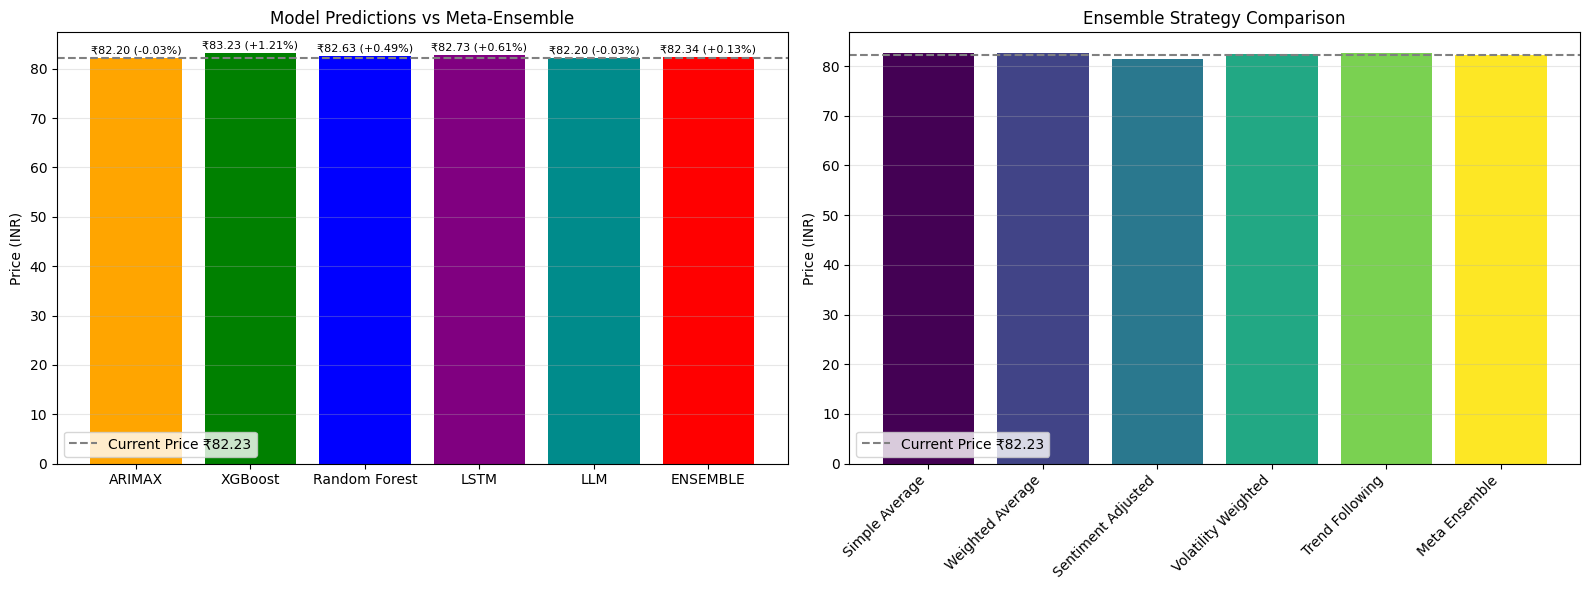


Plot saved to: Data/final_comparison_with_ensemble.png

Results saved to Data/model_predictions_with_ensemble.csv


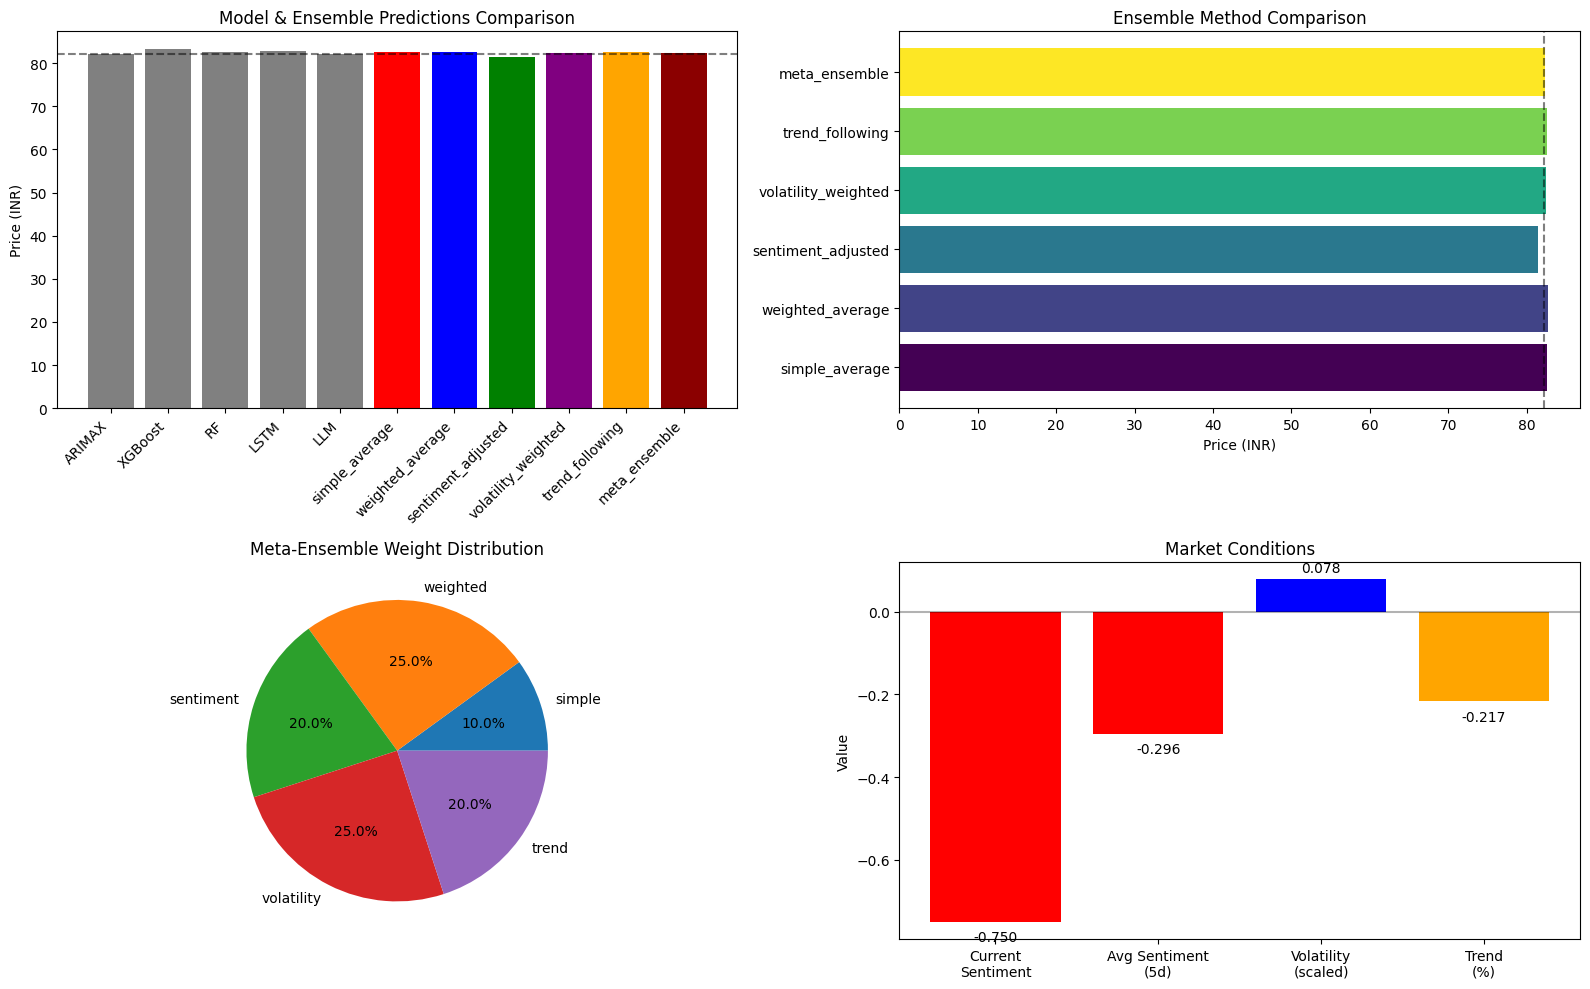


Ensemble analysis saved to: Data/ensemble_analysis.png


In [21]:
# Main function : Collect and process GOLDBEES (Indian Gold ETF) data with technical indicators
# ---------------------------------------------------------------------    
if __name__ == "__main__":
    print(f"GOLDBEES ETF gold price prediction and ensemble analysis")
    print("====================================================")
    start = datetime(2010, 1, 1)
    end = datetime(2026, 1, 1)
    
    # Today's news sentiment weight
    sentiment_weight = -0.75  # Todays news sentiemnt

    # Step 1: Download and save gold ETF price data
    print("\nStep 1: Download and save gold ETF price data")
    print("----------------------------------------------------")
    gold = download_gold_prices(start, end)

    # Step 2: Add and save indicators
    print("\nStep 2: Add and save technical indicators")
    print("----------------------------------------------------")
    if not gold.empty:
        gold = add_technical_indicators(gold)


    # Step 3: Add sentiment based on price trend
    print("\nStep 3: Add sentiment based on price trend")
    print("----------------------------------------------------")
    if not gold.empty:
        # Uncomment one of the following lines to choose the sentiment generation method
        #gold = add_dummy_sentiment(gold)
        #gold = generate_sentiment_from_trend_wo_labels(gold)
        gold = generate_sentiment_from_trend_with_labels(gold, sentiment_weight)


    # Step 4: Predict next day's gold price using ARIMAX
    print("\nStep 4: Predict next day's gold price using ARIMAX")
    print("----------------------------------------------------")
    if not gold.empty:
        # Predict next day's price using ARIMAX with all indicators
        predicted_price_arimax, model_fit, next_day_pct_change = predict_next_day_gold_price_arimax(gold)


    # Step 5: Predict next day's price using XGBoost
    print("\nStep 5: Predict next day's price using XGBoost")
    print("----------------------------------------------------")
    if not gold.empty:
        predicted_price_xgboost, model_fit, next_day_pct_change = predict_next_day_gold_price_xgboost(gold)

    # Step 6: Predict next day's price using Random Forest
    print("\nStep 6: Predict next day's price using Random Forest")
    print("----------------------------------------------------")
    if not gold.empty:
        predicted_price_rf, model_fit, next_day_pct_change = predict_next_day_gold_price_rf(gold)

    # Step 7: Predict next day's price using LSTM
    print("\nStep 7: Predict next day's price using LSTM")
    print("----------------------------------------------------")
    if not gold.empty:
        predicted_price_lstm, model_fit, next_day_pct_change = predict_next_day_gold_price_lstm(gold)

    
    # Step 8: Compare all 4 model predictions.
    print("\nStep 8: Compare & Ensemble all model predictions")
    print("----------------------------------------------------")

    # Ensure we have all predictions before comparing
    """ if not gold.empty:
        actual_close_price = gold['Close'].dropna().iloc[-1]
        compare_model_predictions(
            actual_price=actual_close_price,
            arimax_price=predicted_price_arimax,
            xgb_price=predicted_price_xgboost,
            rf_price=predicted_price_rf,
            lstm_price=predicted_price_lstm
            
            ) """
    
    # Placeholder for LLM prediction
    predicted_price_llm = predicted_price_arimax  # Please change here teh llm predicted price #=========================================      
    
    
    # Get ensemble predictions (will load existing or create new)
    ensemble_results = create_ensemble_predictions(
                        gold=gold,
                        arimax_pred=predicted_price_arimax,
                        xgb_pred=predicted_price_xgboost,
                        rf_pred=predicted_price_rf,
                        lstm_pred=predicted_price_lstm,
                        llm_pred=predicted_price_llm,  # Placeholder for LLM prediction
                        sentiment_weight_boost=1.5,  # Increase for more sentiment emphasis
                    )
    
    # Print summary of predictions and ensemble results
    print ("Ensemble Predictions:")
    print(f"1. Simple Average: ₹{ensemble_results['predictions']['simple_average']:.2f}")
    print(f"2. Weighted Average: ₹{ensemble_results['predictions']['weighted_average']:.2f}")
    print(f"3. Sentiment Adjusted: ₹{ensemble_results['predictions']['sentiment_adjusted']:.2f}")
    print(f"4. Volatility Weighted: ₹{ensemble_results['predictions']['volatility_weighted']:.2f}")
    print(f"5. Trend Following: ₹{ensemble_results['predictions']['trend_following']:.2f}")
    print(f"6. Meta Ensemble: ₹{ensemble_results['predictions']['meta_ensemble']:.2f}") 


    # Print summary of predictions and ensemble results
    print("\n Step 9: Gold price predictions and ensemble results:")
    print("----------------------------------------------------")
    print(f"GOLDBEES ETF gold price: ₹{gold['Close'].iloc[-1]:.2f}")
    print(f"Current news sentiment: {gold['Sentiment'].iloc[-1]:.2f}")

    print(f"\nSummary of next day gold price predictions:")
    print("----------------------------------------------------")
    print(f"1. ARIMAX: ₹{predicted_price_arimax:.2f}") 
    print(f"2. XGBoost: ₹{predicted_price_xgboost:.2f}")
    print(f"3. Random Forest: ₹{predicted_price_rf:.2f}")
    print(f"4. LSTM: ₹{predicted_price_lstm:.2f}")
    print(f"5. LLM: ₹{predicted_price_llm:.2f}")  # Placeholder for LLM prediction
    print(f"6. Meta Ensemble: ₹{ensemble_results['predictions']['meta_ensemble']:.2f}") 
    print("----------------------------------------------------")

    plot_prediction_comparison(
    gold=gold,
    predicted_price_arimax=predicted_price_arimax,
    predicted_price_xgboost=predicted_price_xgboost,
    predicted_price_rf=predicted_price_rf,
    predicted_price_lstm=predicted_price_lstm,
    predicted_price_llm=predicted_price_llm,
    best_ensemble_pred=ensemble_results['predictions']['meta_ensemble'],
    ensemble_results=ensemble_results
    )

    analyze_ensemble_performance(ensemble_results)

                    

Model evaluation code for Arimax

In [22]:
def calculate_accuracy_metrics(actual, predicted, model_name="Model"):
    """
    Calculate various accuracy metrics for model evaluation, with dynamic labels per model name.

    Parameters:
        actual (array-like): Actual values.
        predicted (array-like): Predicted values.
        model_name (str): Name of the model (e.g., "ARIMAX", "XGBoost", etc.).

    Returns:
        dict: A dictionary with accuracy metrics labeled by model.
    """
    import numpy as np
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    actual = np.array(actual)
    predicted = np.array(predicted)

    # Remove NaN values
    mask = ~(np.isnan(actual) | np.isnan(predicted))
    actual = actual[mask]
    predicted = predicted[mask]

    if len(actual) == 0:
        return {f'{model_name}_Error': 'No valid predictions to evaluate'}

    # Core Metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mse = mean_squared_error(actual, predicted)
    r2 = 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2))

    # Directional accuracy (up/down prediction)
    if len(actual) > 1:
        actual_direction = np.diff(actual) > 0
        predicted_direction = np.diff(predicted) > 0
        directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
    else:
        directional_accuracy = 0

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'MSE': mse,
        'R²': r2,
        'Directional_Accuracy': directional_accuracy,
        'Sample_Size': len(actual)
    }

In [23]:

def plot_model_results(results, model_name="ARIMAX", save_path=None):
    """
    Create 4-in-1 plot layout to visualize prediction performance for any model.

    Parameters:
        results (dict): Dictionary containing 'actuals', 'predictions', and optionally 'dates'.
        model_name (str): Name of the model (used in titles).
        save_path (str): Optional path to save the plot image.
    """
    if not results or len(results.get('predictions', [])) == 0:
        print("❌ No results to plot.")
        return

    actuals = results['actuals']
    predictions = results['predictions']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"{model_name} Model Accuracy Test Results", fontsize=16)

    # Plot 1: Actual vs Predicted Prices
    axes[0, 0].plot(range(len(actuals)), actuals, 'b-', label='Actual Prices', linewidth=2, marker='o', markersize=4)
    axes[0, 0].plot(range(len(predictions)), predictions, 'r--', label='Predicted Prices', linewidth=2, marker='s', markersize=4)
    axes[0, 0].set_title('Actual vs Predicted Prices')
    axes[0, 0].set_xlabel('Test Day')
    axes[0, 0].set_ylabel('Price (₹)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Scatter Plot
    axes[0, 1].scatter(actuals, predictions, alpha=0.7, s=50)
    min_val = min(min(actuals), min(predictions))
    max_val = max(max(actuals), max(predictions))
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction', linewidth=2)
    axes[0, 1].set_xlabel('Actual Price (₹)')
    axes[0, 1].set_ylabel('Predicted Price (₹)')
    axes[0, 1].set_title('Scatter Plot: Actual vs Predicted')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Prediction Errors Over Time
    errors = np.array(predictions) - np.array(actuals)
    axes[1, 0].plot(range(len(errors)), errors, 'g-', linewidth=2, marker='D', markersize=3)
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1, 0].fill_between(range(len(errors)), errors, 0, alpha=0.3, color='green')
    axes[1, 0].set_title('Prediction Errors Over Time')
    axes[1, 0].set_xlabel('Test Day')
    axes[1, 0].set_ylabel('Error (Predicted - Actual) ₹')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Error Distribution
    axes[1, 1].hist(errors, bins=min(15, len(errors) // 2 + 1), alpha=0.7,
                   color='skyblue', edgecolor='black', density=True)
    axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    axes[1, 1].axvline(x=np.mean(errors), color='orange', linestyle=':', linewidth=2, label='Mean Error')
    axes[1, 1].set_title('Distribution of Prediction Errors')
    axes[1, 1].set_xlabel('Error (Predicted - Actual) ₹')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # adjust for suptitle

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to: {save_path}")

    plt.show()




In [24]:


def print_model_metrics(results, model_name="ARIMAX"):
    """
    Print detailed accuracy and evaluation metrics for any model.

    Parameters:
        results (dict): Dictionary containing keys like 'metrics', 'actuals', 'predictions', etc.
        model_name (str): Name of the model (used in titles and labels).
    """
    if not results or len(results.get('predictions', [])) == 0:
        print("❌ No results to display")
        return

    # Title header
    print("\n" + "="*70)
    print(f"{model_name.upper()} MODEL - ACCURACY TEST RESULTS")
    print("="*70)

    metrics = results.get('metrics', {})
    test_period = results.get('test_period', len(results['actuals']))
    successful_predictions = results.get('successful_predictions', len(results['predictions']))
    actuals = np.array(results['actuals'])
    predicted = np.array(results['predictions'])
    errors = predicted - actuals


    print(f"Test Period: {test_period} days")
    print(f"Successful Predictions: {successful_predictions}/{test_period}")
    print(f"Success Rate: {(successful_predictions / test_period) * 100:.1f}%")

    # Accuracy metrics
    print(f"\n📊 ACCURACY METRICS:")
    print(f"├── Mean Absolute Error (MAE): ₹{metrics.get('MAE', 0):.2f}")
    print(f"├── Root Mean Squared Error (RMSE): ₹{metrics.get('RMSE', 0):.2f}")
    print(f"├── Mean Absolute Percentage Error (MAPE): {metrics.get('MAPE', 0):.2f}%")
    print(f"├── Mean Squared Error (MSE): {metrics.get('MSE', 0):.2f}")
    print(f"├── R-squared (R²): {metrics.get('R²', 0):.4f}")
    print(f"└── Directional Accuracy: {metrics.get('Directional_Accuracy', 0):.2f}%")

    # Price analysis
    print(f"\n💰 PRICE ANALYSIS:")
    print(f"├── Average Actual Price: ₹{np.mean(actuals):.2f}")
    print(f"├── Average Predicted Price: ₹{np.mean(predicted):.2f}")
    print(f"├── Average Bias: ₹{np.mean(predicted - actuals):.2f}")
    print(f"├── Largest Overestimate: ₹{np.max(errors):.2f}")
    print(f"└── Largest Underestimate: ₹{np.min(errors):.2f}")

    """ # Performance summary
    mape = metrics.get('MAPE', float('inf'))
    print(f"\n🎯 PERFORMANCE RATING:")
    if mape < 2:
        print("🏆 EXCELLENT - Model is highly accurate!")
    elif mape < 5:
        print("📈 VERY GOOD - Model performs well!")
    elif mape < 10:
        print("📊 GOOD - Model is reasonably accurate!")
    elif mape < 20:
        print("⚠️  FAIR - Needs improvement.")
    else:
        print("❌ POOR - Consider tuning the model or features.")

    print("="*70) """


    # Enhanced Performance Evaluation based on MAPE and Directional Accuracy
    print(f"\n🎯 PERFORMANCE EVALUATION:")
    print("-" * 40)

    mape = metrics.get('MAPE', float('inf'))
    r2 = metrics.get('R²', 0)
    directional_acc = metrics.get('Directional_Accuracy', 0)

    # Price Accuracy Rating
    if mape < 2:
        price_rating = "Excellent"
    elif mape < 5:
        price_rating = "Good"
    elif mape < 10:
        price_rating = "Fair"
    else:
        price_rating = "Poor"

    # Direction Accuracy Rating
    if directional_acc > 70:
        direction_rating = "Excellent"
    elif directional_acc > 60:
        direction_rating = "Good"
    elif directional_acc > 50:
        direction_rating = "Fair"
    else:
        direction_rating = "Poor"

    print(f"Price Accuracy Rating    : {price_rating} (MAPE: {mape:.2f}%)")
    print(f"Direction Accuracy Rating: {direction_rating} ({directional_acc:.1f}%)")
    print(f"Model Fit (R²)          : {r2:.4f}")




In [25]:
import matplotlib.pyplot as plt
import numpy as np

def backtest_arimax(df: pd.DataFrame, arima_order=(1, 1, 1), train_window=100, test_horizon=30):
    """
    Backtests ARIMAX model using a rolling window over the test horizon.
    Returns predictions, actuals, corresponding dates, and accuracy metrics.
    """
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from utils import calculate_accuracy_metrics, plot_model_results, print_model_metrics

    # Define exogenous features
    exog_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    # Preprocess the data
    df = df[['Close'] + exog_cols].dropna()
    df = df.asfreq('B')
    df.ffill(inplace=True)

    y_full = df['Close']
    exog_full = df[exog_cols]

    actuals, predictions, prediction_dates = [], [], []
    successful_tests = 0
    total_available = len(df)
    test_days = 0

    max_i = total_available - test_horizon - train_window + 1

    for i in range(max_i, total_available - 1):
        y_train = y_full.iloc[i:i + train_window]
        exog_train = exog_full.iloc[i:i + train_window]

        test_index = i + train_window
        if test_index >= total_available:
            break

        y_test = y_full.iloc[test_index]
        exog_test = exog_full.iloc[[test_index]]
        test_date = y_full.index[test_index]

        try:
            model = SARIMAX(endog=y_train, exog=exog_train, order=arima_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False, method='powell')
            y_pred = model_fit.forecast(steps=1, exog=exog_test).iloc[0]

            actuals.append(y_test)
            predictions.append(y_pred)
            prediction_dates.append(test_date)
            test_days += 1

            error = y_pred - y_test
            print(f"Day {test_days:2d} | Date: {test_date.date()} | Actual: ₹{y_test:.2f} | "
                  f"Predicted: ₹{y_pred:.2f} | Error: ₹{error:.2f}")

            if np.sign(y_pred - y_train.iloc[-1]) == np.sign(y_test - y_train.iloc[-1]):
                successful_tests += 1

        except Exception as e:
            print(f"Skipping test at index {test_index} due to error: {e}")
            continue

    # Calculate accuracy metrics
    metrics = calculate_accuracy_metrics(actuals, predictions, model_name="ARIMAX")

    results = {
        'predictions': predictions,
        'actuals': actuals,
        'dates': prediction_dates,
        'metrics': metrics,
        'test_period': test_days,
        'successful_predictions': successful_tests
    }

    # Call external reporting functions
    plot_model_results(results, model_name="ARIMAX")
    print_model_metrics(results, model_name="ARIMAX")

    return results


Day  1 | Date: 2025-02-04 | Actual: ₹70.10 | Predicted: ₹70.01 | Error: ₹-0.09
Day  2 | Date: 2025-02-05 | Actual: ₹71.66 | Predicted: ₹71.58 | Error: ₹-0.08
Day  3 | Date: 2025-02-06 | Actual: ₹71.52 | Predicted: ₹71.72 | Error: ₹0.20
Day  4 | Date: 2025-02-07 | Actual: ₹71.53 | Predicted: ₹71.63 | Error: ₹0.10
Day  5 | Date: 2025-02-10 | Actual: ₹72.50 | Predicted: ₹72.38 | Error: ₹-0.12
Day  6 | Date: 2025-02-11 | Actual: ₹71.97 | Predicted: ₹72.03 | Error: ₹0.06
Day  7 | Date: 2025-02-12 | Actual: ₹71.48 | Predicted: ₹71.63 | Error: ₹0.15
Day  8 | Date: 2025-02-13 | Actual: ₹71.87 | Predicted: ₹71.61 | Error: ₹-0.26
Day  9 | Date: 2025-02-14 | Actual: ₹72.22 | Predicted: ₹72.10 | Error: ₹-0.12
Day 10 | Date: 2025-02-17 | Actual: ₹71.63 | Predicted: ₹71.71 | Error: ₹0.08
Day 11 | Date: 2025-02-18 | Actual: ₹71.97 | Predicted: ₹71.81 | Error: ₹-0.16
Day 12 | Date: 2025-02-19 | Actual: ₹72.80 | Predicted: ₹72.46 | Error: ₹-0.34
Day 13 | Date: 2025-02-20 | Actual: ₹72.46 | Predicted: ₹

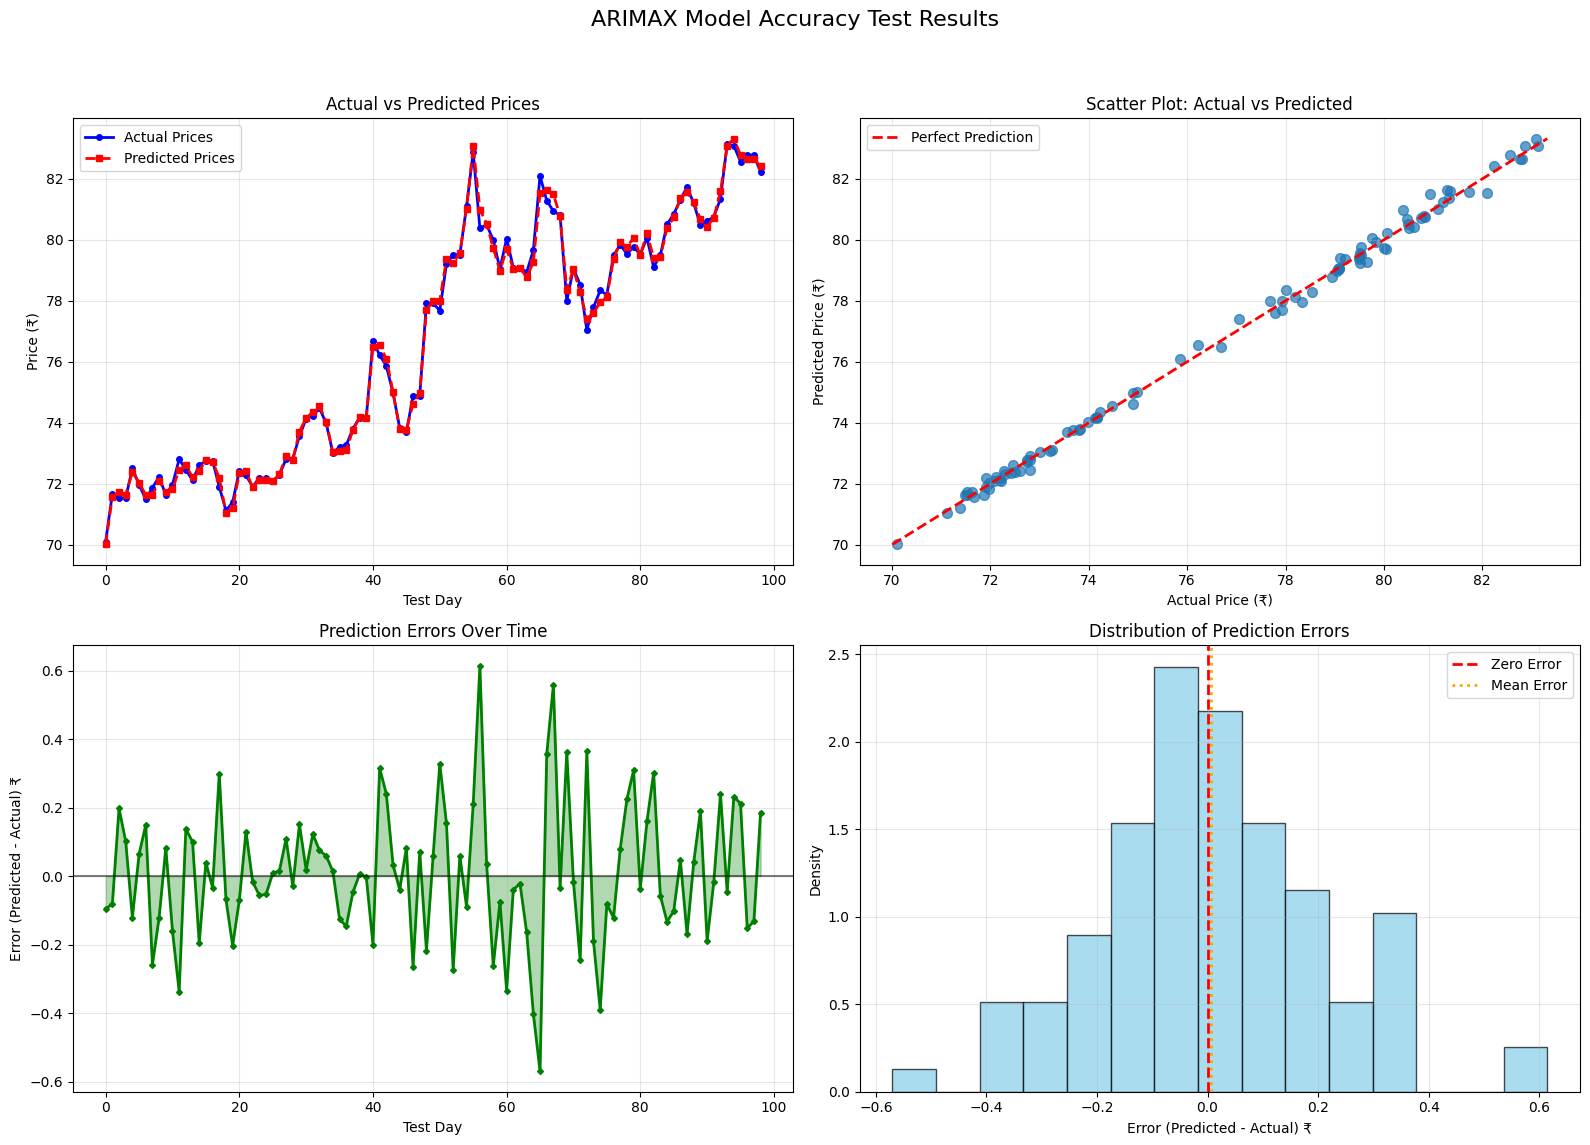


ARIMAX MODEL - ACCURACY TEST RESULTS
Test Period: 99 days
Successful Predictions: 86/99
Success Rate: 86.9%

📊 ACCURACY METRICS:
├── Mean Absolute Error (MAE): ₹0.15
├── Root Mean Squared Error (RMSE): ₹0.20
├── Mean Absolute Percentage Error (MAPE): 0.20%
├── Mean Squared Error (MSE): 0.04
├── R-squared (R²): 0.9973
└── Directional Accuracy: 81.63%

💰 PRICE ANALYSIS:
├── Average Actual Price: ₹76.66
├── Average Predicted Price: ₹76.66
├── Average Bias: ₹0.01
├── Largest Overestimate: ₹0.61
└── Largest Underestimate: ₹-0.57

🎯 PERFORMANCE EVALUATION:
----------------------------------------
Price Accuracy Rating    : Excellent (MAPE: 0.20%)
Direction Accuracy Rating: Excellent (81.6%)
Model Fit (R²)          : 0.9973


In [26]:
# Calling the validation functions on the ARIMAX backtest results
results_arima = backtest_arimax(df=gold, arima_order=(1, 1, 1), train_window=600, test_horizon=100)


Model evaluation code for XGBoost

In [27]:
from utils import calculate_accuracy_metrics, plot_model_results, print_model_metrics


# Define the updated function
def evaluate_xgboost_gold_model_exact(gold_df, lookback_days=60, test_size=0.2, random_state=42, train_window_days=None):
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]
    
    gold_clean = gold_df[['Close'] + feature_cols].copy().dropna()
    gold_clean['Close_pct_change_1'] = gold_clean['Close'].pct_change(1)
    gold_clean['Close_pct_change_2'] = gold_clean['Close'].pct_change(2)
    gold_clean['Close_pct_change_3'] = gold_clean['Close'].pct_change(3)
    gold_clean['Close_rolling_std_5'] = gold_clean['Close'].rolling(5).std()
    gold_clean['Close_rolling_std_10'] = gold_clean['Close'].rolling(10).std()
    gold_clean['Close_vs_MA5'] = (gold_clean['Close'] - gold_clean['MA_5']) / gold_clean['MA_5']
    gold_clean['Close_vs_MA20'] = (gold_clean['Close'] - gold_clean['MA_20']) / gold_clean['MA_20']
    
    feature_cols_extended = feature_cols + [
        'Close_pct_change_1', 'Close_pct_change_2', 'Close_pct_change_3',
        'Close_rolling_std_5', 'Close_rolling_std_10',
        'Close_vs_MA5', 'Close_vs_MA20'
    ]
    
    gold_clean = gold_clean.dropna()
    gold_clean['Target_pct_change'] = gold_clean['Close'].pct_change().shift(-1)
    gold_clean['Target_price'] = gold_clean['Close'].shift(-1)
    gold_clean = gold_clean.dropna()
    
    gold_clean = gold_clean[
        (np.isfinite(gold_clean['Target_pct_change'])) &
        (np.abs(gold_clean['Target_pct_change']) < 1.0)
    ]
    
    print(f"Total data points available: {len(gold_clean)}")
    total_points = len(gold_clean)
    test_start_idx = max(0, total_points - lookback_days - 1)
    print(f"Testing predictions for last {min(lookback_days, total_points - test_start_idx - 1)} days")
    
    actual_prices, predicted_prices = [], []
    actual_pct_changes, predicted_pct_changes = [], []
    current_prices, prediction_dates = [], []
    
    for i in range(test_start_idx, total_points - 1):
        if train_window_days:
            train_start_idx = max(0, i + 1 - train_window_days)
            train_data = gold_clean.iloc[train_start_idx:i+1].copy()
        else:
            train_data = gold_clean.iloc[:i+1].copy()

        X = train_data[feature_cols_extended]
        y_pct = train_data['Target_pct_change']
        
        split_idx = int(len(X) * (1 - test_size))
        X_train, y_pct_train = X.iloc[:split_idx], y_pct.iloc[:split_idx]
        
        if len(X_train) < 50:
            continue
        
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        model = xgb.XGBRegressor(
            n_estimators=400,
            max_depth=10,
            learning_rate=0.008,
            min_child_weight=1,
            subsample=0.95,
            colsample_bytree=0.9,
            reg_alpha=0.001,
            reg_lambda=0.01,
            gamma=0,
            random_state=random_state,
            objective='reg:squarederror',
            tree_method='hist'
        )
        
        model.fit(X_train_scaled, y_pct_train)
        
        latest_features = train_data[feature_cols_extended].iloc[[-1]]
        latest_price = train_data['Close'].iloc[-1]
        
        #pred_scaler = RobustScaler().fit(train_data[feature_cols_extended])
        #latest_scaled = pred_scaler.transform(latest_features)
        latest_scaled = scaler.transform(latest_features)
        
        next_day_pct_change = model.predict(latest_scaled)[0]
        next_day_price = latest_price * (1 + next_day_pct_change)
        
        actual_next_price = gold_clean['Close'].iloc[i + 1]
        actual_next_pct_change = gold_clean['Target_pct_change'].iloc[i]
        
        current_prices.append(latest_price)
        predicted_prices.append(next_day_price)
        actual_prices.append(actual_next_price)
        predicted_pct_changes.append(next_day_pct_change)
        actual_pct_changes.append(actual_next_pct_change)
        prediction_dates.append(gold_clean.index[i + 1])
        
        if len(predicted_prices) % 10 == 0:
            print(f"Completed {len(predicted_prices)} predictions...")
    
    if len(actual_prices) == 0:
        print("Error: No predictions could be made. Try reducing lookback_days or checking data.")
        return None
    
    print(f"\nCompleted {len(actual_prices)} predictions")
    
    print("Actual sample:", actual_prices[:5])
    print("Predicted sample:", predicted_prices[:5])
    print("Len actual:", len(actual_prices), "Len predicted:", len(predicted_prices))

    results = {
        'actuals': np.array(actual_prices),
        'predictions': np.array(predicted_prices),
        'dates': prediction_dates,
        'metrics': calculate_accuracy_metrics(actual_prices, predicted_prices, model_name="XGBoost"),
        'test_period': len(actual_prices),
        'successful_predictions': len(predicted_prices)
    }
    


    plot_model_results(results, model_name="XGBoost")
    print_model_metrics(results, model_name="XGBoost")
    
    return results


Total data points available: 3730
Testing predictions for last 100 days
Completed 10 predictions...
Completed 20 predictions...
Completed 30 predictions...
Completed 40 predictions...
Completed 50 predictions...
Completed 60 predictions...
Completed 70 predictions...
Completed 80 predictions...
Completed 90 predictions...
Completed 100 predictions...

Completed 100 predictions
Actual sample: [np.float64(67.43000030517578), np.float64(67.7699966430664), np.float64(67.68000030517578), np.float64(67.56999969482422), np.float64(67.87000274658203)]
Predicted sample: [np.float64(67.23301827135583), np.float64(66.6645789755512), np.float64(67.21855301489086), np.float64(67.81768217148874), np.float64(67.52256396672692)]
Len actual: 100 Len predicted: 100


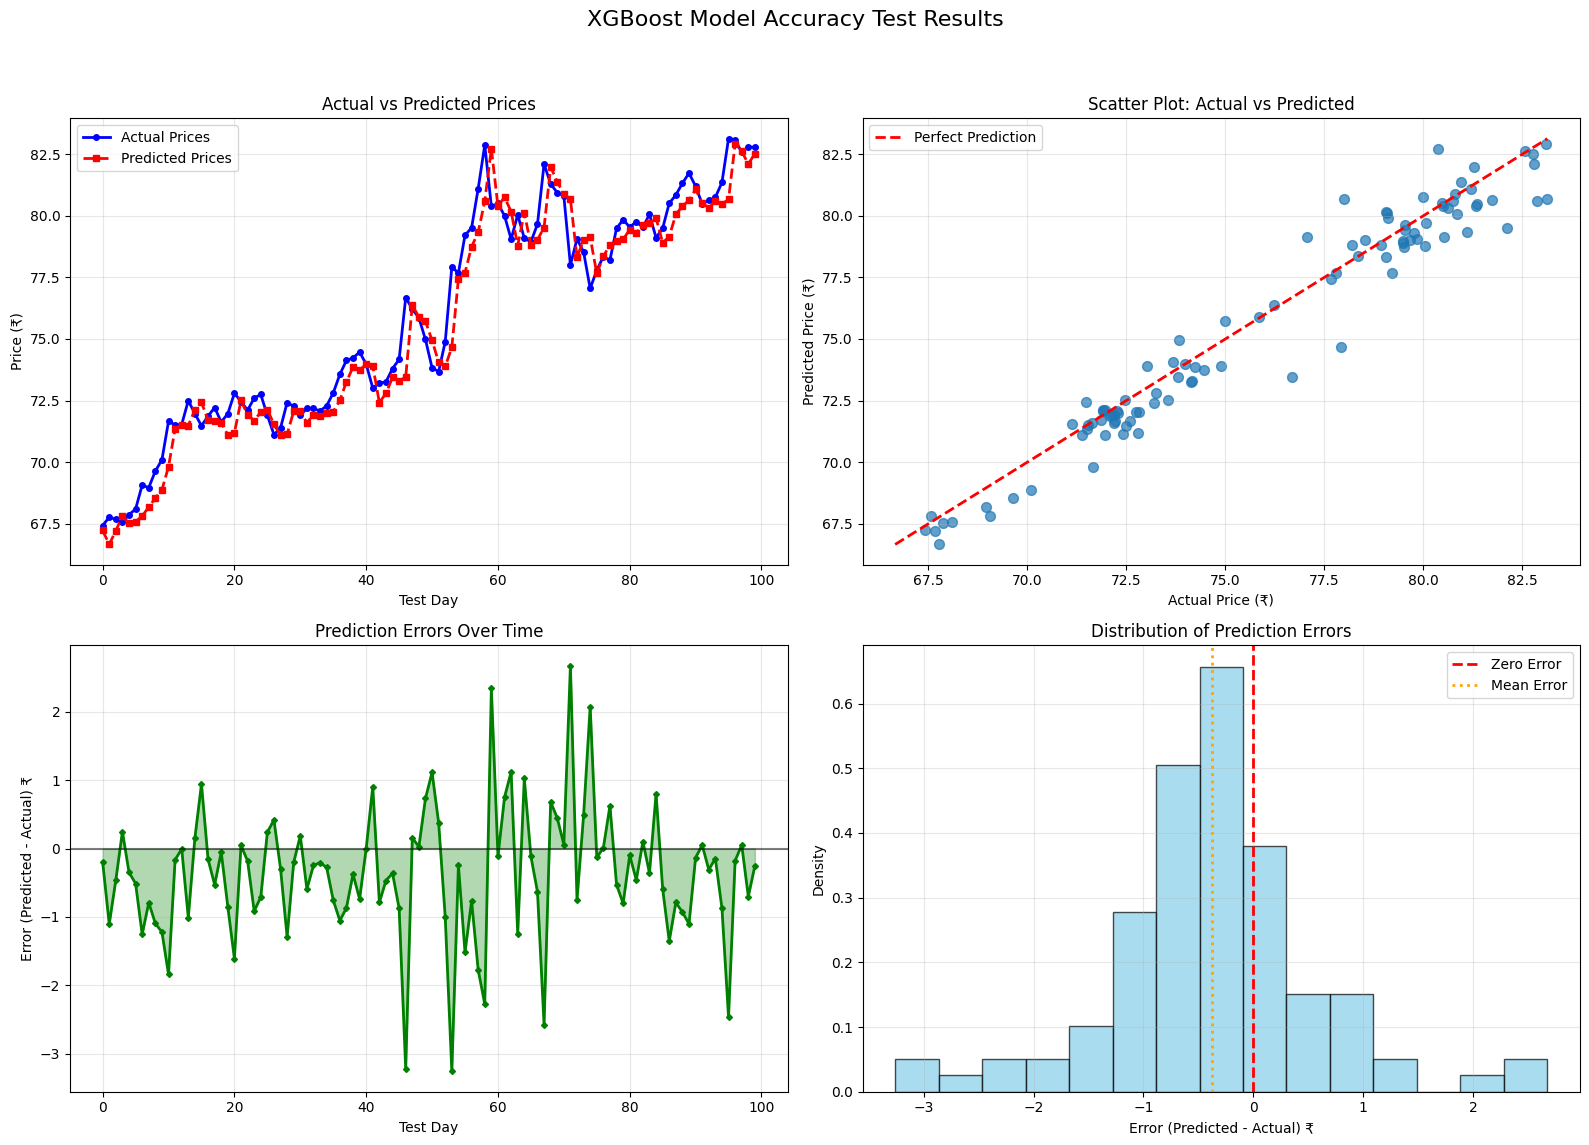


XGBOOST MODEL - ACCURACY TEST RESULTS
Test Period: 100 days
Successful Predictions: 100/100
Success Rate: 100.0%

📊 ACCURACY METRICS:
├── Mean Absolute Error (MAE): ₹0.75
├── Root Mean Squared Error (RMSE): ₹1.03
├── Mean Absolute Percentage Error (MAPE): 0.98%
├── Mean Squared Error (MSE): 1.05
├── R-squared (R²): 0.9468
└── Directional Accuracy: 50.51%

💰 PRICE ANALYSIS:
├── Average Actual Price: ₹75.90
├── Average Predicted Price: ₹75.53
├── Average Bias: ₹-0.37
├── Largest Overestimate: ₹2.68
└── Largest Underestimate: ₹-3.26

🎯 PERFORMANCE EVALUATION:
----------------------------------------
Price Accuracy Rating    : Excellent (MAPE: 0.98%)
Direction Accuracy Rating: Fair (50.5%)
Model Fit (R²)          : 0.9468


In [28]:
# Example: Test XGBoost on last 45 days with training window of past 120 days each time
results_xgboost = evaluate_xgboost_gold_model_exact(
    gold_df=gold,
    lookback_days=100,
    test_size=0.2,
    random_state=42,
    #train_window_days=120  # Optional; remove to use full history
)

Model evaluation code for Random Forest

In [29]:
from utils import calculate_accuracy_metrics, plot_model_results, print_model_metrics

def backtest_random_forest_full_pipeline(gold_data, test_days=60, min_train_days=200, show_plots=True):
    """
    Full pipeline backtesting for Random Forest with formatted result return.
    """
    print("🧪 Starting full pipeline Random Forest backtest...")

    # Step 1: Prepare features
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]
    
    gold_clean = gold_data[['Close'] + feature_cols].copy().dropna()
    gold_clean['Close_pct_change_1'] = gold_clean['Close'].pct_change(1)
    gold_clean['Close_pct_change_2'] = gold_clean['Close'].pct_change(2)
    gold_clean['Close_pct_change_3'] = gold_clean['Close'].pct_change(3)
    gold_clean['Close_rolling_std_5'] = gold_clean['Close'].rolling(5).std()
    gold_clean['Close_rolling_std_10'] = gold_clean['Close'].rolling(10).std()
    gold_clean['Close_vs_MA5'] = (gold_clean['Close'] - gold_clean['MA_5']) / gold_clean['MA_5']
    gold_clean['Close_vs_MA20'] = (gold_clean['Close'] - gold_clean['MA_20']) / gold_clean['MA_20']
    gold_clean['Price_momentum_3'] = gold_clean['Close'] / gold_clean['Close'].shift(3) - 1
    gold_clean['Price_momentum_5'] = gold_clean['Close'] / gold_clean['Close'].shift(5) - 1

    feature_cols_extended = feature_cols + [
        'Close_pct_change_1', 'Close_pct_change_2', 'Close_pct_change_3',
        'Close_rolling_std_5', 'Close_rolling_std_10',
        'Close_vs_MA5', 'Close_vs_MA20',
        'Price_momentum_3', 'Price_momentum_5'
    ]

    gold_clean.dropna(inplace=True)
    gold_clean['Target_pct_change'] = gold_clean['Close'].pct_change().shift(-1)
    gold_clean['Target_price'] = gold_clean['Close'].shift(-1)
    gold_clean.dropna(inplace=True)
    gold_clean = gold_clean[np.abs(gold_clean['Target_pct_change']) < 1.0]

    if len(gold_clean) < min_train_days + test_days:
        print(f"❌ Not enough data. Needed: {min_train_days + test_days}, Got: {len(gold_clean)}")
        return None

    # Step 2: Perform backtest
    results = {
        'dates': [], 'actual_prices': [], 'predicted_prices': [],
        'actual_pct_changes': [], 'predicted_pct_changes': [], 'current_prices': []
    }

    for i in range(len(gold_clean) - test_days, len(gold_clean)):
        if i < min_train_days:
            continue

        try:
            data_up_to_day = gold_clean.iloc[:i].copy()
            X = data_up_to_day[feature_cols_extended]
            y = data_up_to_day['Target_pct_change']
            scaler = RobustScaler()
            X_scaled = scaler.fit_transform(X)

            model = RandomForestRegressor(
                n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2,
                max_features='sqrt', bootstrap=True, random_state=42, n_jobs=-1
            )
            model.fit(X_scaled, y)

            latest_features = data_up_to_day[feature_cols_extended].iloc[[-1]]
            latest_price = data_up_to_day['Close'].iloc[-1]
            latest_scaled = RobustScaler().fit(data_up_to_day[feature_cols_extended]).transform(latest_features)
            predicted_pct_change = model.predict(latest_scaled)[0]
            predicted_price = latest_price * (1 + predicted_pct_change)

            actual_row = gold_clean.iloc[i]
            actual_price = actual_row['Target_price']
            actual_pct = actual_row['Target_pct_change']

            results['dates'].append(gold_clean.index[i])
            results['current_prices'].append(latest_price)
            results['predicted_prices'].append(predicted_price)
            results['actual_prices'].append(actual_price)
            results['predicted_pct_changes'].append(predicted_pct_change)
            results['actual_pct_changes'].append(actual_pct)

        except Exception as e:
            print(f"⚠️ Skipped index {i} due to: {str(e)}")
            continue

    if len(results['dates']) == 0:
        print("❌ No successful predictions.")
        return None

    # Step 3: Final formatting
    actuals = np.array(results['actual_prices'])
    predictions = np.array(results['predicted_prices'])
    metrics = calculate_accuracy_metrics(actuals, predictions, model_name="Random Forest")

    final_results = {
        'actuals': actuals,
        'predictions': predictions,
        'dates': results['dates'],
        'metrics': metrics,
        'test_period': len(actuals),
        'successful_predictions': len(predictions),
    }

    print_model_metrics(final_results, model_name="Random Forest")
    if show_plots:
        plot_model_results(final_results, model_name="Random Forest")

    return final_results

🧪 Starting full pipeline Random Forest backtest...

RANDOM FOREST MODEL - ACCURACY TEST RESULTS
Test Period: 100 days
Successful Predictions: 100/100
Success Rate: 100.0%

📊 ACCURACY METRICS:
├── Mean Absolute Error (MAE): ₹0.83
├── Root Mean Squared Error (RMSE): ₹1.08
├── Mean Absolute Percentage Error (MAPE): 1.09%
├── Mean Squared Error (MSE): 1.16
├── R-squared (R²): 0.9405
└── Directional Accuracy: 45.45%

💰 PRICE ANALYSIS:
├── Average Actual Price: ₹76.05
├── Average Predicted Price: ₹75.83
├── Average Bias: ₹-0.21
├── Largest Overestimate: ₹2.72
└── Largest Underestimate: ₹-3.74

🎯 PERFORMANCE EVALUATION:
----------------------------------------
Price Accuracy Rating    : Excellent (MAPE: 1.09%)
Direction Accuracy Rating: Poor (45.5%)
Model Fit (R²)          : 0.9405


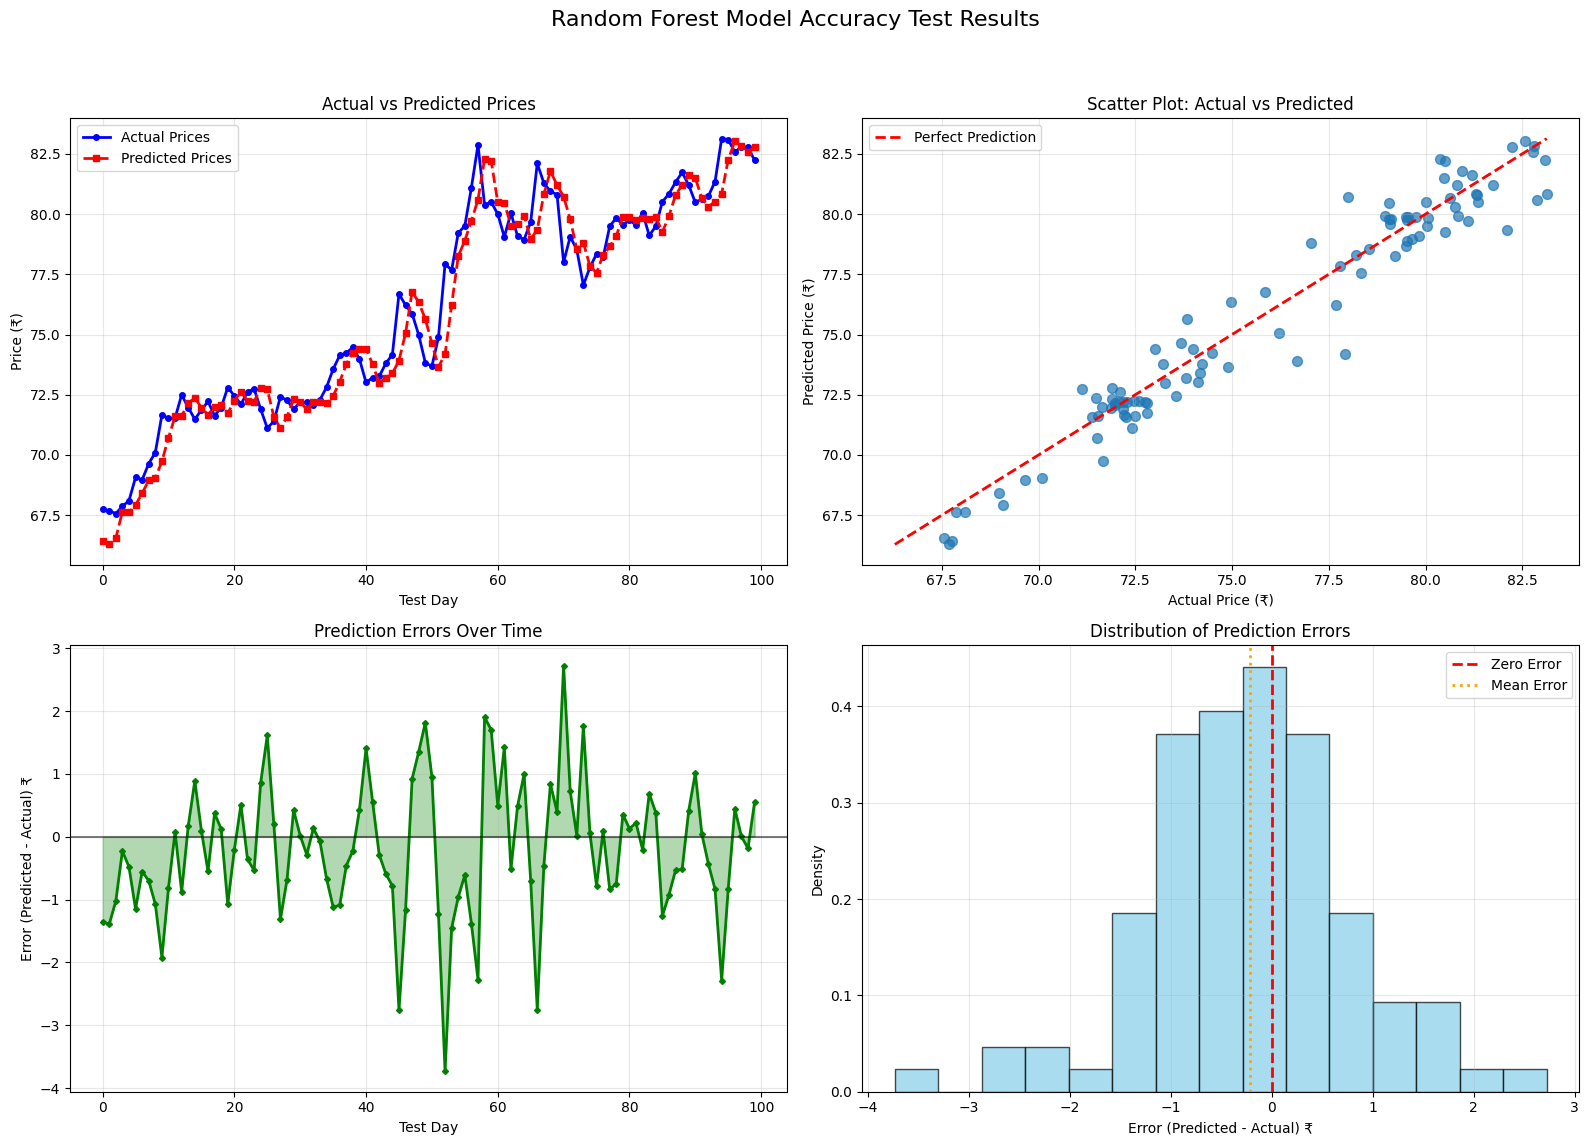

In [30]:
results_rf = backtest_random_forest_full_pipeline(gold_data=gold, test_days=100, min_train_days=600)


Model evaluation code for LSTM

In [31]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from utils import print_model_metrics, calculate_accuracy_metrics, plot_model_results

# Custom dataset class
class GoldPriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# LSTM backtesting function
def backtest_lstm_model(gold_df, test_days=30, sequence_length=10, epochs=50, batch_size=16, lr=0.001, show_plots=True):
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]
    
    predictions, actuals, dates = [], [], []
    
    for day_back in range(test_days, 0, -1):
        idx = len(gold_df) - day_back
        train_data = gold_df.iloc[:idx]
        
        # Prepare features
        data = train_data[['Close'] + feature_cols].dropna().copy()
        data['Target'] = data['Close'].shift(-1)
        data.dropna(inplace=True)
        
        if len(data) < sequence_length + 10:
            continue
        
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_scaled = scaler_x.fit_transform(data[feature_cols])
        y_scaled = scaler_y.fit_transform(data[['Target']])
        
        X_seq, y_seq = [], []
        for i in range(len(X_scaled) - sequence_length):
            X_seq.append(X_scaled[i:i+sequence_length])
            y_seq.append(y_scaled[i+sequence_length])
        
        X_seq = np.array(X_seq)
        y_seq = np.array(y_seq)
        
        if len(X_seq) == 0:
            continue
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        model = LSTMModel(input_size=X_seq.shape[2]).to(device)
        
        train_ds = GoldPriceDataset(X_seq, y_seq)
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        model.train()
        print(f"Training LSTM for day back: {day_back}")
        for _ in range(epochs):            
            for xb, yb in train_dl:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb).squeeze(), yb.squeeze())
                loss.backward()
                optimizer.step()
        
        model.eval()
        print(f"Making predictions for day back: {day_back}")
        with torch.no_grad():
            input_seq = torch.tensor(X_scaled[-sequence_length:], dtype=torch.float32).unsqueeze(0).to(device)
            pred_scaled = model(input_seq).cpu().numpy()
        
        pred = scaler_y.inverse_transform(
            np.concatenate([np.zeros((1, len(feature_cols))), pred_scaled], axis=1)
        )[:, -1][0]
        
        actual = data['Target'].iloc[-1]
        predictions.append(pred)
        actuals.append(actual)
        dates.append(data.index[-1])
    
    if len(predictions) == 0:
        print("❌ No predictions made!")
        return None

    # Convert to arrays
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Format final output structure
    final_results = {
        'actuals': actuals,
        'predictions': predictions,
        'dates': dates,
        'metrics': calculate_accuracy_metrics(actuals, predictions, model_name="LSTM"),
        'test_period': len(actuals),
        'successful_predictions': len(predictions),
    }

    # Print and plot
    print_model_metrics(final_results, model_name="LSTM")
    if show_plots:
        plot_model_results(final_results, model_name="LSTM")

    return final_results


Using device: cuda
Training LSTM for day back: 100
Making predictions for day back: 100
Using device: cuda
Training LSTM for day back: 99
Making predictions for day back: 99
Using device: cuda
Training LSTM for day back: 98
Making predictions for day back: 98
Using device: cuda
Training LSTM for day back: 97
Making predictions for day back: 97
Using device: cuda
Training LSTM for day back: 96
Making predictions for day back: 96
Using device: cuda
Training LSTM for day back: 95
Making predictions for day back: 95
Using device: cuda
Training LSTM for day back: 94
Making predictions for day back: 94
Using device: cuda
Training LSTM for day back: 93
Making predictions for day back: 93
Using device: cuda
Training LSTM for day back: 92
Making predictions for day back: 92
Using device: cuda
Training LSTM for day back: 91
Making predictions for day back: 91
Using device: cuda
Training LSTM for day back: 90
Making predictions for day back: 90
Using device: cuda
Training LSTM for day back: 89
Ma

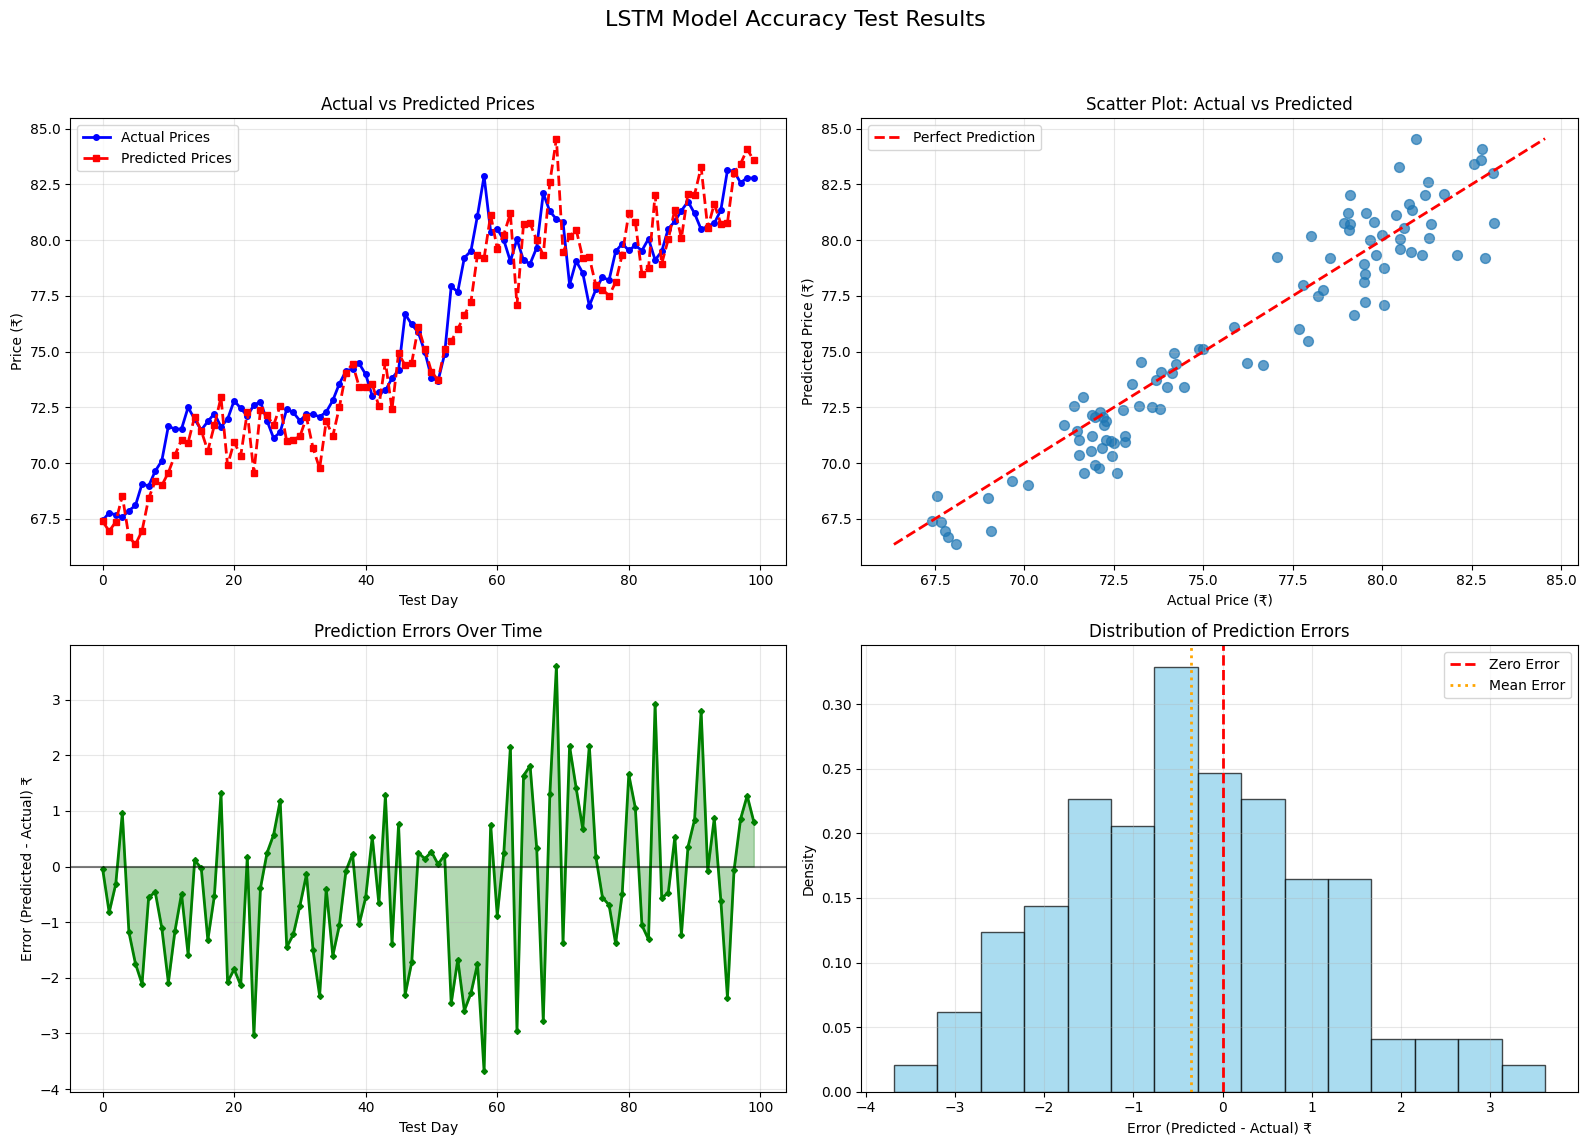

In [32]:
# Run backtesting
results_lstm = backtest_lstm_model(gold, test_days=100, sequence_length=10, epochs=50)

In [33]:
def plot_combined_predictions(results_dict, title="Gold Price Prediction - Model Comparison"):
    """
    Plot actual vs predicted prices for multiple models on a single graph.

    Parameters:
    - results_dict: Dictionary with model names as keys and results as values (must contain 'dates', 'actuals', 'predictions').
    - title: Title for the combined plot.
    """
    plt.figure(figsize=(16, 9))
    
    # Extract common actuals and dates from the first model (assumed to be correct)
    base_model = next(iter(results_dict.values()))
    common_dates = base_model['dates']
    actual_prices = base_model['actuals']

    # Plot actual prices
    plt.plot(common_dates, actual_prices, label='Actual Price', color='black', linewidth=2.5, linestyle='--', marker='o')

    # Plot predicted prices for each model
    for model_name, result in results_dict.items():
        plt.plot(result['dates'], result['predictions'], label=f"{model_name} Prediction", linewidth=2.0, marker='s')

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Gold Price (₹)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



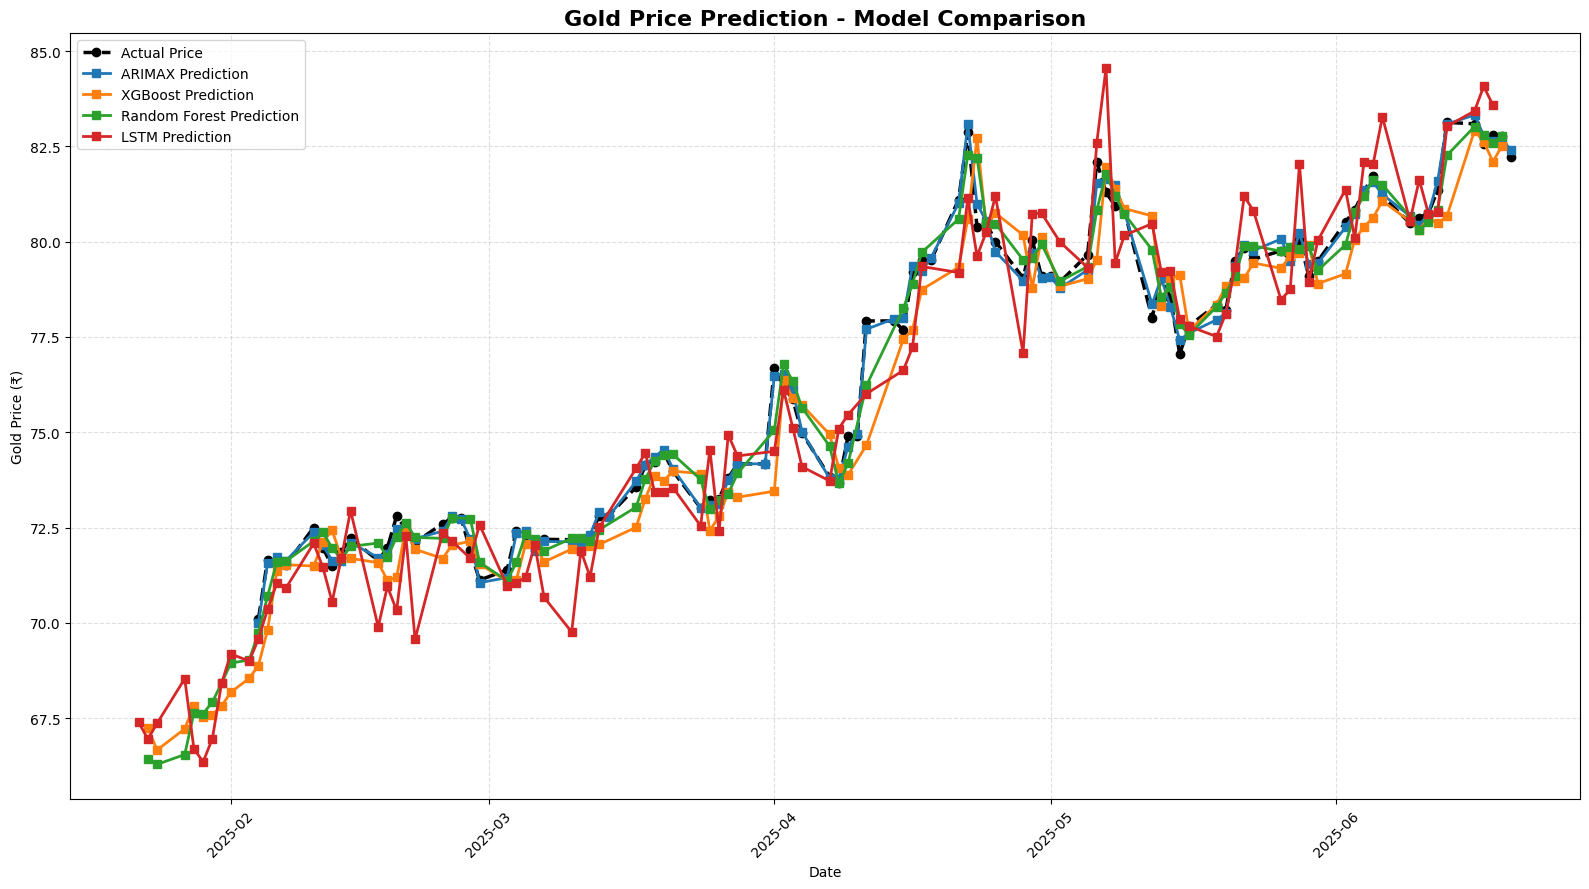

In [34]:
# Call the combined plot with your result objects
plot_combined_predictions({
    "ARIMAX": results_arima,
    "XGBoost": results_xgboost,
    "Random Forest": results_rf,
    "LSTM": results_lstm
})

In [35]:
def print_model_comparison_table_min(results_dict):
    """
    Prints a comparison table of evaluation metrics for different models.

    Handles both flat and nested metric dictionaries.
    """
    print("\n📊 MODEL COMPARISON TABLE (Last 30 Days)")
    print("─" * 85)
    header = f"{'Model':<15} {'MAE (₹)':<10} {'RMSE (₹)':<10} {'MAPE (%)':<10} {'R²':<10} {'Dir. Acc (%)':<15}"
    print(header)
    print("─" * 85)
    
    for model_name, result in results_dict.items():
        metrics = result.get('metrics', {})
        
        # Attempt to read from nested structure first, fallback to flat
        if 'Price Metrics' in metrics:
            price = metrics['Price Metrics']
            direction = metrics.get('Percentage Change Metrics', {})
        else:
            price = metrics
            direction = metrics

        mae = price.get('MAE', 0)
        rmse = price.get('RMSE', 0)
        mape = price.get('MAPE (%)', 0)
        r2 = price.get('R² Score', 0)
        dir_acc = direction.get('Directional Accuracy (%)', 0)

        row = f"{model_name:<15} ₹{mae:<9.2f} ₹{rmse:<9.2f} {mape:<10.2f} {r2:<10.4f} {dir_acc:<15.2f}"
        print(row)

    print("─" * 85)


In [36]:
# Call the table print function
print_model_comparison_table_min({
    "ARIMAX": results_arima,
    "XGBoost": results_xgboost,
    "Random Forest": results_rf,
    "LSTM": results_lstm
})


📊 MODEL COMPARISON TABLE (Last 30 Days)
─────────────────────────────────────────────────────────────────────────────────────
Model           MAE (₹)    RMSE (₹)   MAPE (%)   R²         Dir. Acc (%)   
─────────────────────────────────────────────────────────────────────────────────────
ARIMAX          ₹0.15      ₹0.20      0.00       0.0000     0.00           
XGBoost         ₹0.75      ₹1.03      0.00       0.0000     0.00           
Random Forest   ₹0.83      ₹1.08      0.00       0.0000     0.00           
LSTM            ₹1.17      ₹1.45      0.00       0.0000     0.00           
─────────────────────────────────────────────────────────────────────────────────────


In [37]:
def print_model_comparison_table(results_dict):
    """
    Prints a detailed comparison table of evaluation metrics and predictions 
    for multiple models, including price prediction stats.
    """
    print("\n📊 MODEL COMPARISON TABLE (Last Prediction Snapshot)")
    print("─" * 130)
    header = f"{'Model':<15} {'Current (₹)':<13} {'Predicted (₹)':<15} {'Bias (₹)':<10} {'% Change':<10} {'MAE':<8} {'RMSE':<8} {'MAPE (%)':<10} {'R²':<8} {'DirAcc (%)':<10}"
    print(header)
    print("─" * 130)

    for model_name, result in results_dict.items():
        metrics = result.get('metrics', {})
        
        # Try nested (like Random Forest/XGBoost) or fallback to flat (like LSTM)
        if 'Price Metrics' in metrics:
            price = metrics['Price Metrics']
            direction = metrics.get('Percentage Change Metrics', {})
        else:
            price = metrics
            direction = metrics

        # Accuracy metrics
        mae = price.get('MAE', 0)
        rmse = price.get('RMSE', 0)
        mape = price.get('MAPE (%)', 0)
        r2 = price.get('R² Score', 0)
        dir_acc = direction.get('Directional Accuracy (%)', 0)

        # Price comparison
        current_price = result['actuals'][-1] if 'actuals' in result else 0
        predicted_price = result['predictions'][-1] if 'predictions' in result else 0
        bias = predicted_price - current_price
        percent_change = (bias / current_price) * 100 if current_price != 0 else 0

        row = f"{model_name:<15} ₹{current_price:<12.2f} ₹{predicted_price:<14.2f} ₹{bias:<9.2f} {percent_change:<9.2f}% {mae:<8.2f} {rmse:<8.2f} {mape:<10.2f} {r2:<8.4f} {dir_acc:<10.2f}"
        print(row)

    print("─" * 130)


In [38]:
# Call the table print function
print_model_comparison_table({
    "ARIMAX": results_arima,
    "XGBoost": results_xgboost,
    "Random Forest": results_rf,
    "LSTM": results_lstm
})


📊 MODEL COMPARISON TABLE (Last Prediction Snapshot)
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model           Current (₹)   Predicted (₹)   Bias (₹)   % Change   MAE      RMSE     MAPE (%)   R²       DirAcc (%)
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
ARIMAX          ₹82.23        ₹82.42          ₹0.19      0.23     % 0.15     0.20     0.00       0.0000   0.00      
XGBoost         ₹82.77        ₹82.52          ₹-0.25     -0.30    % 0.75     1.03     0.00       0.0000   0.00      
Random Forest   ₹82.23        ₹82.78          ₹0.55      0.67     % 0.83     1.08     0.00       0.0000   0.00      
LSTM            ₹82.77        ₹83.58          ₹0.81      0.98     % 1.17     1.45     0.00       0.0000   0.00      
────────────────────────────────────────────────────────────────────────────────────────────────────

In [39]:
def save_backtest_results(results_dict, output_folder="Backtest_results"):
    os.makedirs(output_folder, exist_ok=True)

    for model_name, result in results_dict.items():
        filename = f"{model_name.lower().replace(' ', '_')}_results.pkl"
        filepath = os.path.join(output_folder, filename)
        with open(filepath, 'wb') as f:
            pickle.dump(result, f)
        print(f"✅ Saved {model_name} results to: {filepath}")


In [40]:
# Save all to /Backtest_results
all_results = {
    "ARIMAX": results_arima,
    "XGBoost": results_xgboost,
    "Random Forest": results_rf,
    "LSTM": results_lstm
}

save_backtest_results(all_results, output_folder="Backtest_results")

✅ Saved ARIMAX results to: Backtest_results\arimax_results.pkl
✅ Saved XGBoost results to: Backtest_results\xgboost_results.pkl
✅ Saved Random Forest results to: Backtest_results\random_forest_results.pkl
✅ Saved LSTM results to: Backtest_results\lstm_results.pkl


In [41]:
import os
import pickle

def load_backtest_results(folder_path="Backtest_results"):
    """Load all saved model results from the specified folder."""
    results = {}
    for file in os.listdir(folder_path):
        if file.endswith("_results.pkl"):
            model_name = file.replace("_results.pkl", "").replace("_", " ").title()
            with open(os.path.join(folder_path, file), 'rb') as f:
                results[model_name] = pickle.load(f)
            print(f"📂 Loaded: {model_name}")
    return results


In [42]:
from utils import print_model_metrics, plot_model_results, print_model_comparison_table

def analyze_all_backtest_results(folder_path="Backtest_results", show_plots=True, compare_table=True):
    results = load_backtest_results(folder_path)
    
    # Print & plot individual metrics
    for model_name, result in results.items():
        print(f"\n🔍 {model_name} ANALYSIS")
        print("=" * 60)
        print_model_metrics(result, model_name=model_name)
        if show_plots:
            plot_model_results(result, model_name=model_name)

    # Comparison table
    if compare_table:
        print("\n📊 MODEL COMPARISON SUMMARY")
        print("=" * 60)
        print_model_comparison_table(results)

    # Save raw data to CSV
    #results.to_csv("Backtest_results/Backtest_results_combined.csv")
    #print("Saved Backtest_results_combined.csv")    
    return results


📂 Loaded: Arimax
📂 Loaded: Lstm
📂 Loaded: Random Forest
📂 Loaded: Xgboost

🔍 Arimax ANALYSIS

ARIMAX MODEL - ACCURACY TEST RESULTS
Test Period: 99 days
Successful Predictions: 86/99
Success Rate: 86.9%

📊 ACCURACY METRICS:
├── Mean Absolute Error (MAE): ₹0.15
├── Root Mean Squared Error (RMSE): ₹0.20
├── Mean Absolute Percentage Error (MAPE): 0.20%
├── Mean Squared Error (MSE): 0.04
├── R-squared (R²): 0.9973
└── Directional Accuracy: 81.63%

💰 PRICE ANALYSIS:
├── Average Actual Price: ₹76.66
├── Average Predicted Price: ₹76.66
├── Average Bias: ₹0.01
├── Largest Overestimate: ₹0.61
└── Largest Underestimate: ₹-0.57

🎯 PERFORMANCE EVALUATION:
----------------------------------------
Price Accuracy Rating    : Excellent (MAPE: 0.20%)
Direction Accuracy Rating: Excellent (81.6%)
Model Fit (R²)          : 0.9973


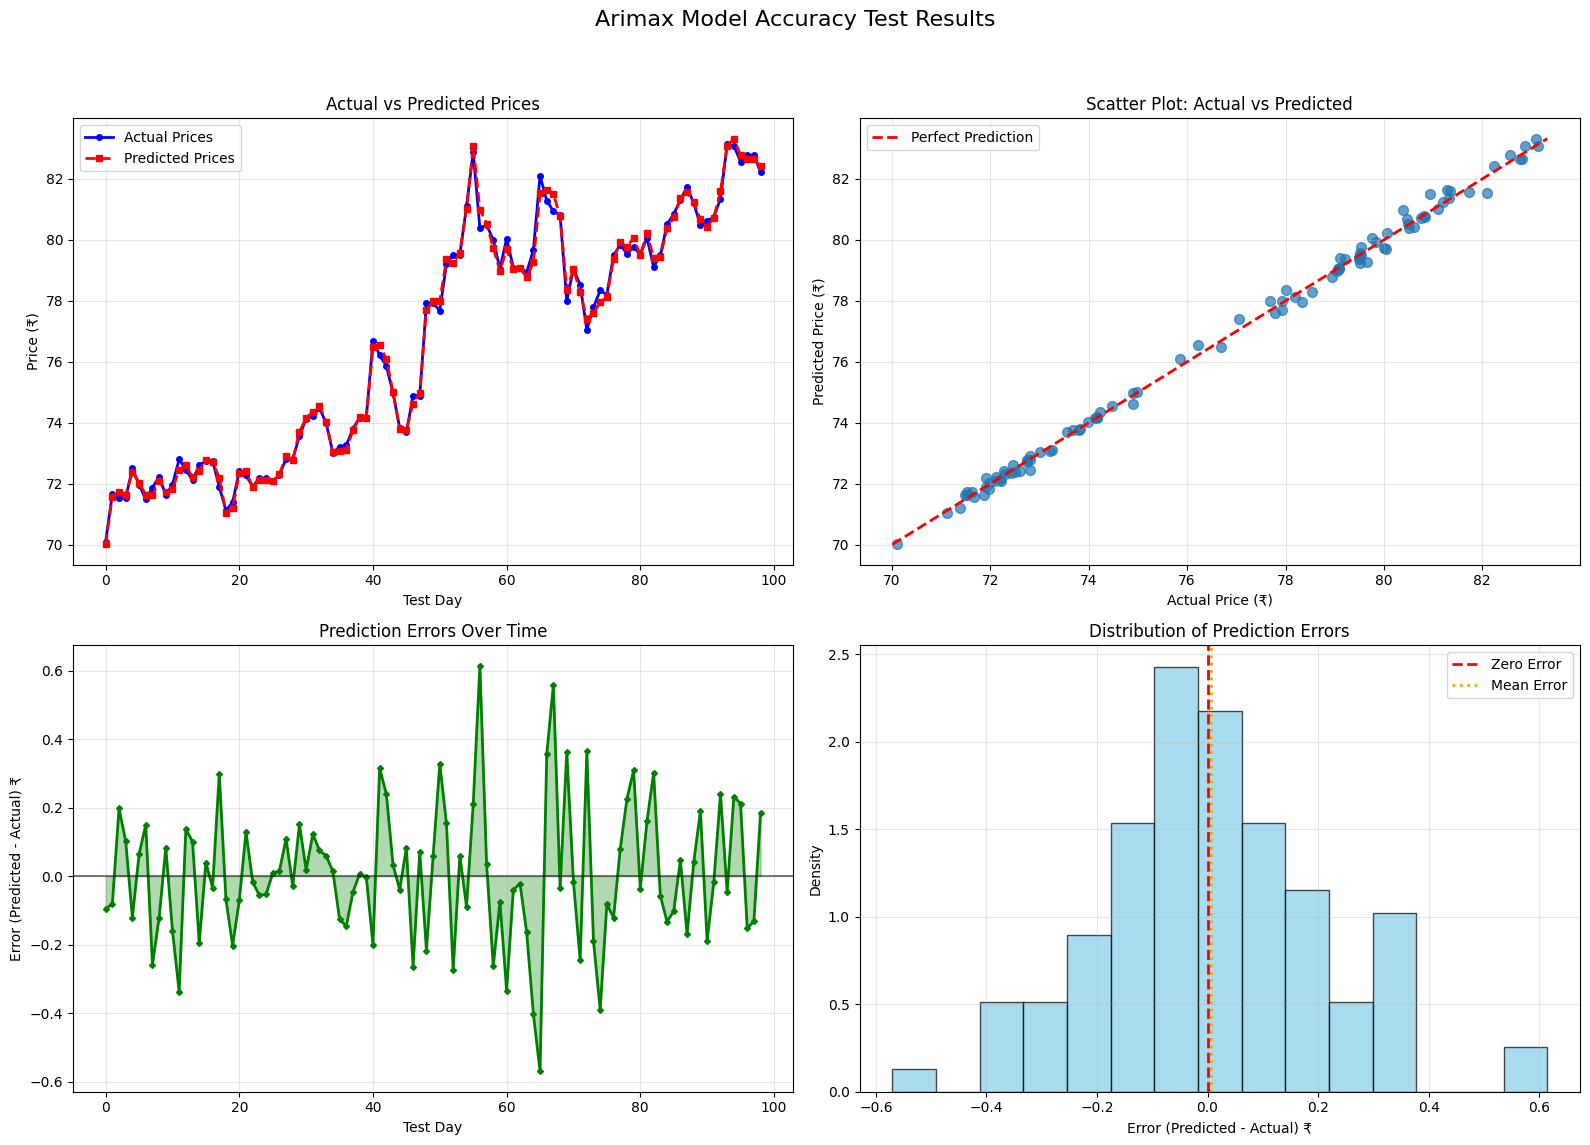


🔍 Lstm ANALYSIS

LSTM MODEL - ACCURACY TEST RESULTS
Test Period: 100 days
Successful Predictions: 100/100
Success Rate: 100.0%

📊 ACCURACY METRICS:
├── Mean Absolute Error (MAE): ₹1.17
├── Root Mean Squared Error (RMSE): ₹1.45
├── Mean Absolute Percentage Error (MAPE): 1.53%
├── Mean Squared Error (MSE): 2.12
├── R-squared (R²): 0.8932
└── Directional Accuracy: 46.46%

💰 PRICE ANALYSIS:
├── Average Actual Price: ₹75.90
├── Average Predicted Price: ₹75.54
├── Average Bias: ₹-0.36
├── Largest Overestimate: ₹3.61
└── Largest Underestimate: ₹-3.68

🎯 PERFORMANCE EVALUATION:
----------------------------------------
Price Accuracy Rating    : Excellent (MAPE: 1.53%)
Direction Accuracy Rating: Poor (46.5%)
Model Fit (R²)          : 0.8932


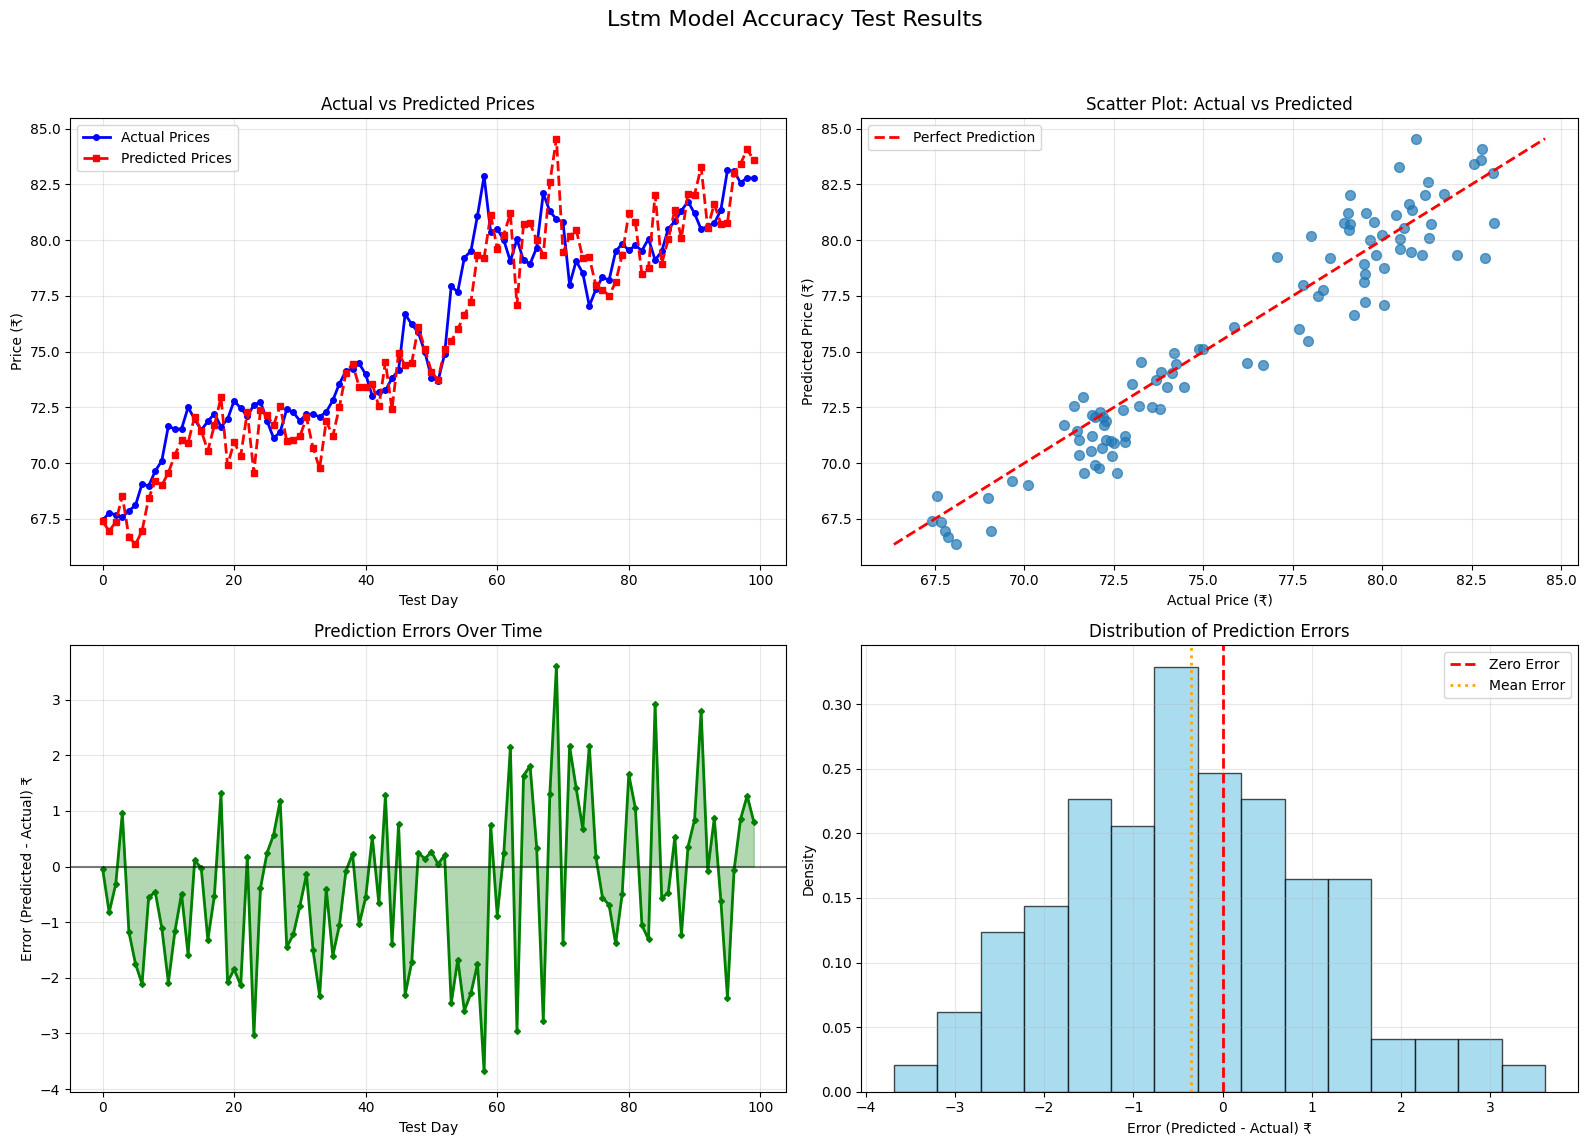


🔍 Random Forest ANALYSIS

RANDOM FOREST MODEL - ACCURACY TEST RESULTS
Test Period: 100 days
Successful Predictions: 100/100
Success Rate: 100.0%

📊 ACCURACY METRICS:
├── Mean Absolute Error (MAE): ₹0.83
├── Root Mean Squared Error (RMSE): ₹1.08
├── Mean Absolute Percentage Error (MAPE): 1.09%
├── Mean Squared Error (MSE): 1.16
├── R-squared (R²): 0.9405
└── Directional Accuracy: 45.45%

💰 PRICE ANALYSIS:
├── Average Actual Price: ₹76.05
├── Average Predicted Price: ₹75.83
├── Average Bias: ₹-0.21
├── Largest Overestimate: ₹2.72
└── Largest Underestimate: ₹-3.74

🎯 PERFORMANCE EVALUATION:
----------------------------------------
Price Accuracy Rating    : Excellent (MAPE: 1.09%)
Direction Accuracy Rating: Poor (45.5%)
Model Fit (R²)          : 0.9405


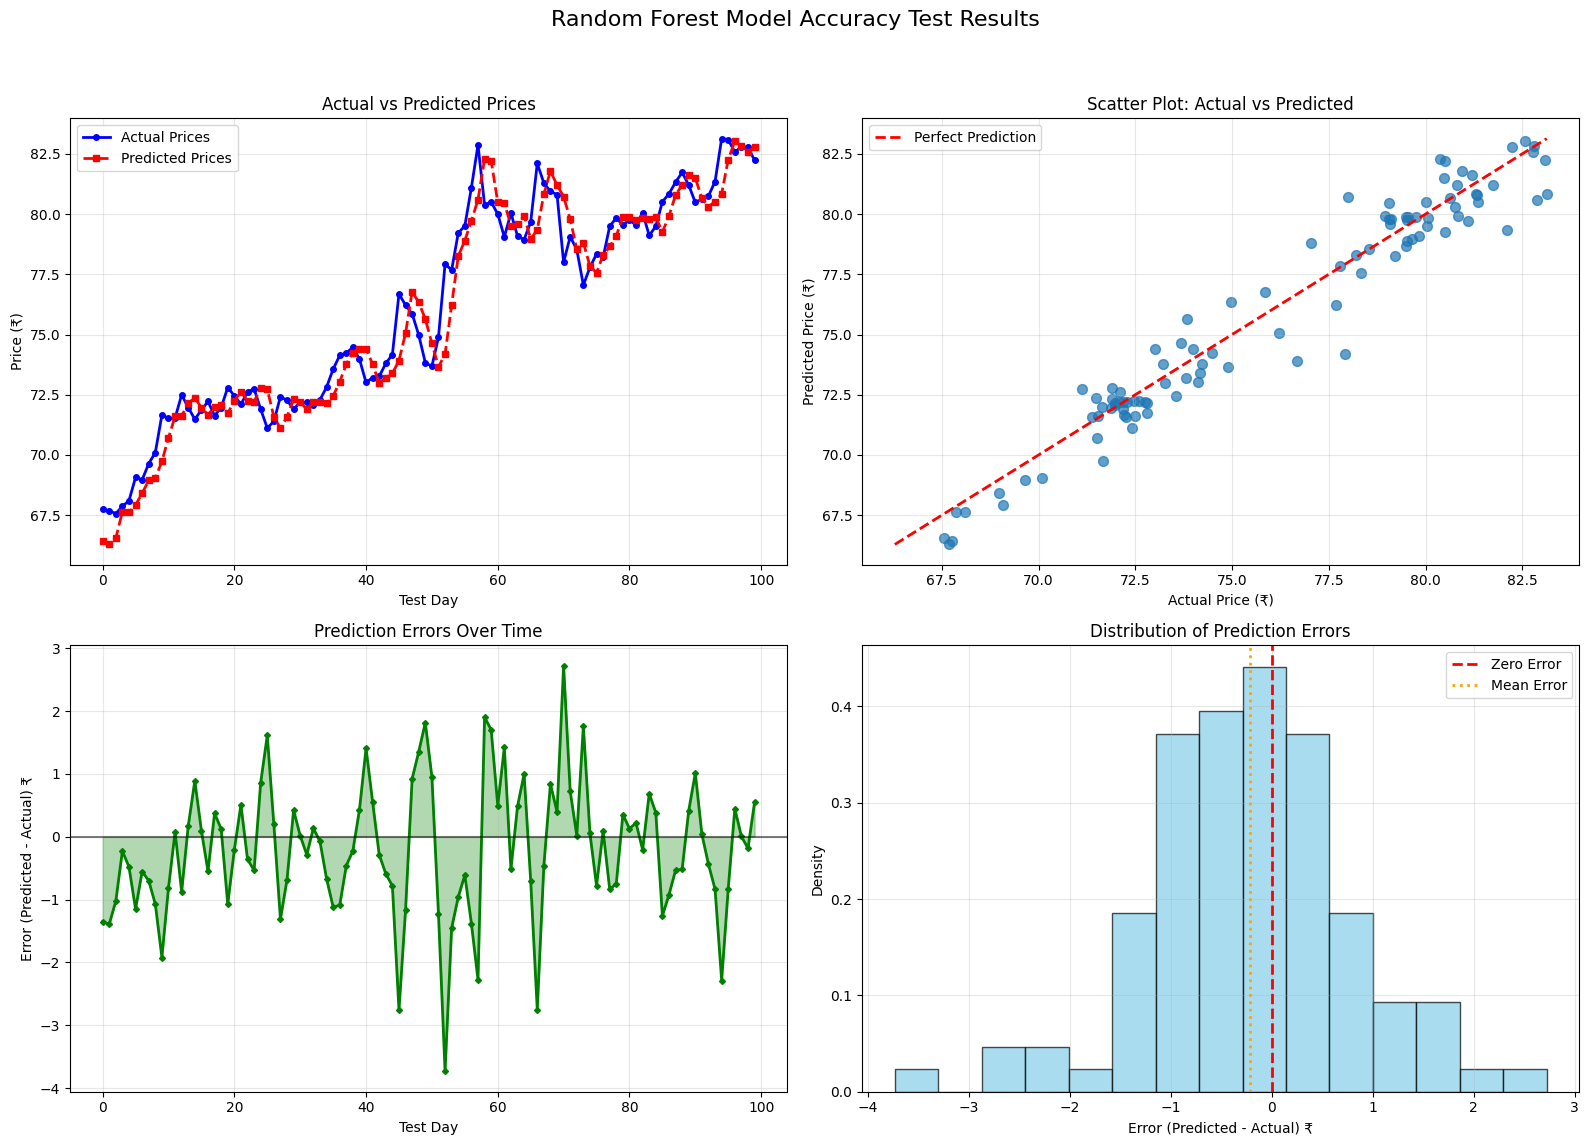


🔍 Xgboost ANALYSIS

XGBOOST MODEL - ACCURACY TEST RESULTS
Test Period: 100 days
Successful Predictions: 100/100
Success Rate: 100.0%

📊 ACCURACY METRICS:
├── Mean Absolute Error (MAE): ₹0.75
├── Root Mean Squared Error (RMSE): ₹1.03
├── Mean Absolute Percentage Error (MAPE): 0.98%
├── Mean Squared Error (MSE): 1.05
├── R-squared (R²): 0.9468
└── Directional Accuracy: 50.51%

💰 PRICE ANALYSIS:
├── Average Actual Price: ₹75.90
├── Average Predicted Price: ₹75.53
├── Average Bias: ₹-0.37
├── Largest Overestimate: ₹2.68
└── Largest Underestimate: ₹-3.26

🎯 PERFORMANCE EVALUATION:
----------------------------------------
Price Accuracy Rating    : Excellent (MAPE: 0.98%)
Direction Accuracy Rating: Fair (50.5%)
Model Fit (R²)          : 0.9468


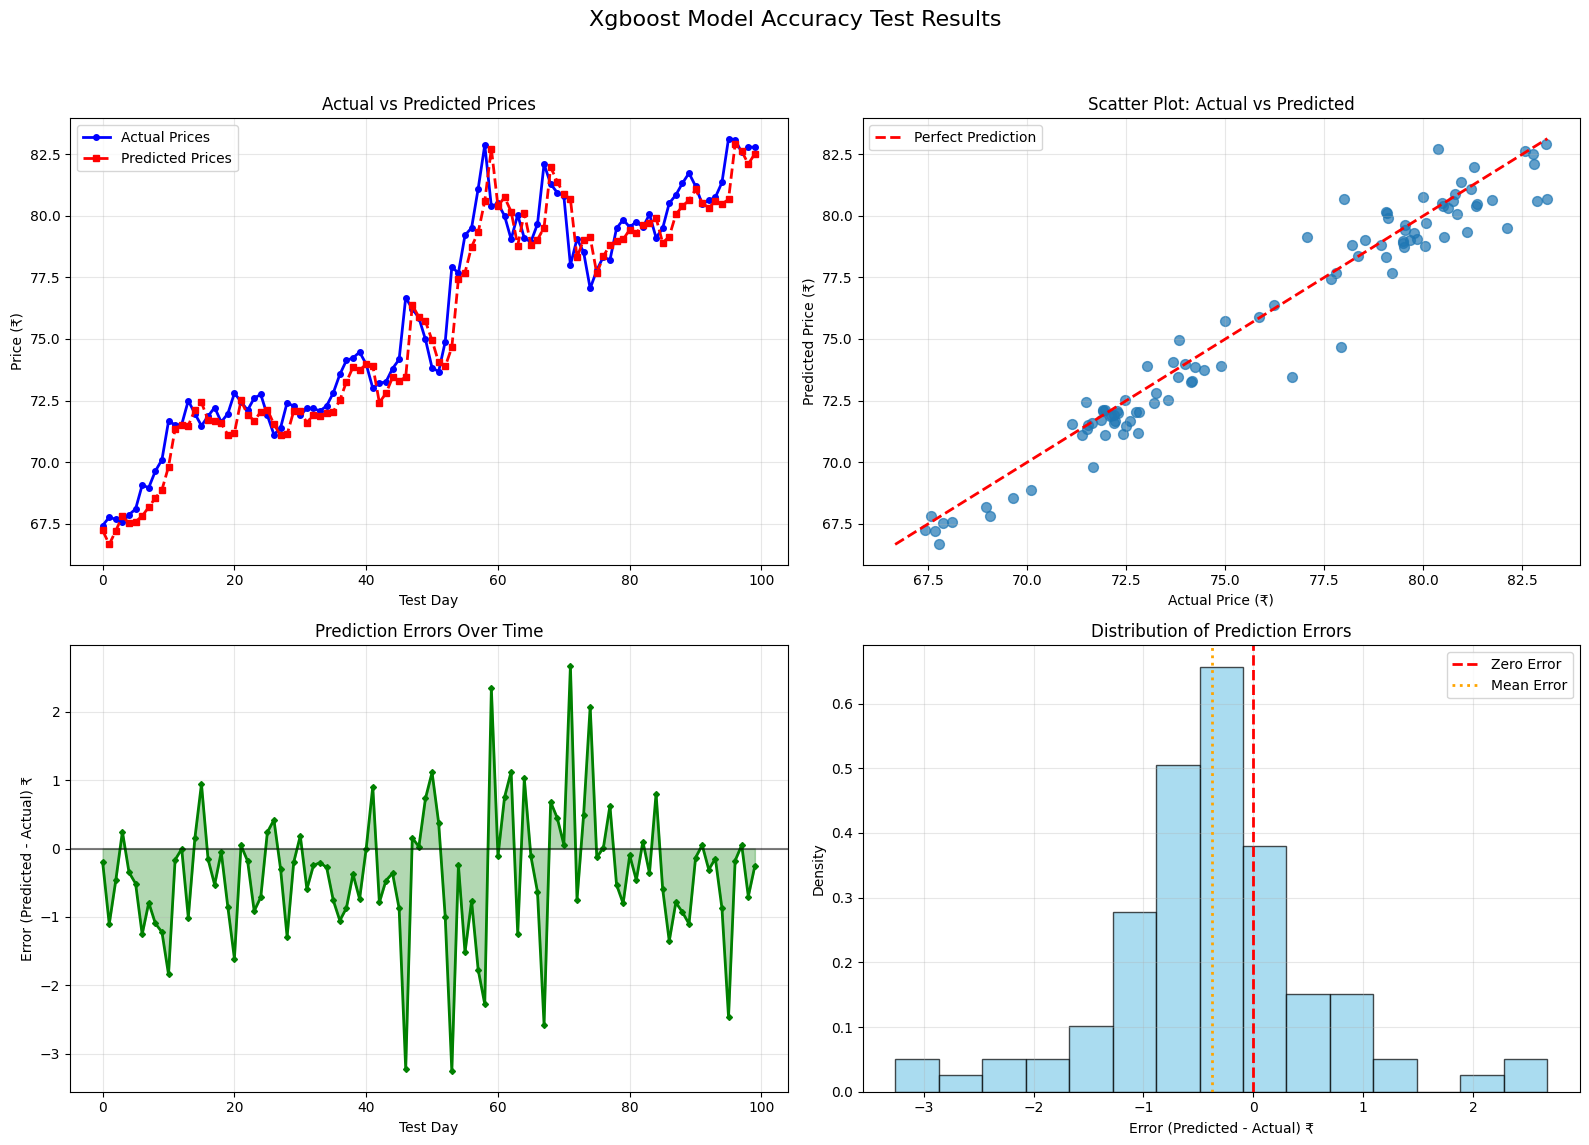


📊 MODEL COMPARISON SUMMARY

📊 MODEL COMPARISON TABLE (Last Prediction Snapshot)
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model           Current (₹)   Predicted (₹)   Bias (₹)   % Change   MAE      RMSE     MAPE (%)   R²       DirAcc (%)
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Arimax          ₹82.23        ₹82.42          ₹0.19      0.23     % 0.15     0.20     0.00       0.0000   0.00      
Lstm            ₹82.77        ₹83.58          ₹0.81      0.98     % 1.17     1.45     0.00       0.0000   0.00      
Random Forest   ₹82.23        ₹82.78          ₹0.55      0.67     % 0.83     1.08     0.00       0.0000   0.00      
Xgboost         ₹82.77        ₹82.52          ₹-0.25     -0.30    % 0.75     1.03     0.00       0.0000   0.00      
────────────────────────────────────────────────────────────────────────

{'Arimax': {'predictions': [np.float64(70.00537314591386),
   np.float64(71.57773022684762),
   np.float64(71.7179965658389),
   np.float64(71.63176586910338),
   np.float64(72.3786768550067),
   np.float64(72.03370784881561),
   np.float64(71.62990665228388),
   np.float64(71.61133135472812),
   np.float64(72.09860950633954),
   np.float64(71.71293111577604),
   np.float64(71.80979591377351),
   np.float64(72.46251417296445),
   np.float64(72.59751694424479),
   np.float64(72.21019898348716),
   np.float64(72.40472547239266),
   np.float64(72.78960808806131),
   np.float64(72.71634747066351),
   np.float64(72.19904093721242),
   np.float64(71.05197236446057),
   np.float64(71.18702985703248),
   np.float64(72.34950776022708),
   np.float64(72.39969044683262),
   np.float64(71.88317488723136),
   np.float64(72.1336533245969),
   np.float64(72.12679602711088),
   np.float64(72.08828702930582),
   np.float64(72.30550176479522),
   np.float64(72.91914274884415),
   np.float64(72.781351450

In [43]:
# Analyze everything
analyze_all_backtest_results("Backtest_results")

In [44]:
import os
import pandas as pd

def save_all_backtest_results_to_csv(results_dict, folder_path="Backtest_results"):
    """
    Saves actuals, predictions, and dates from all model results to individual CSV files.

    Args:
        results_dict (dict): Dictionary of model_name -> results_dict (must contain 'actuals', 'predictions', 'dates').
        folder_path (str): Directory where the CSVs will be saved.
    """
    os.makedirs(folder_path, exist_ok=True)

    for model_name, result in results_dict.items():
        actuals = result.get('actuals', [])
        predictions = result.get('predictions', [])
        dates = result.get('dates', [])

        # Construct DataFrame
        df = pd.DataFrame({
            'Date': dates,
            'Actual Price': actuals,
            'Predicted Price': predictions
        })

        # Save to CSV
        filename = f"{model_name.lower().replace(' ', '_')}_results.csv"
        file_path = os.path.join(folder_path, filename)
        df.to_csv(file_path, index=False)
        print(f"✅ Saved {model_name} results to {file_path}")


In [45]:
save_all_backtest_results_to_csv({
    "Arimax": results_arima,
    "Xgboost": results_xgboost,
    "Random_Forest": results_rf,
    "Lstm": results_lstm
})

✅ Saved Arimax results to Backtest_results\arimax_results.csv
✅ Saved Xgboost results to Backtest_results\xgboost_results.csv
✅ Saved Random_Forest results to Backtest_results\random_forest_results.csv
✅ Saved Lstm results to Backtest_results\lstm_results.csv
